In [1]:
!which pip3

/home/mgross/anaconda3/envs/contrast-net/bin/pip3


In [2]:
! nvidia-smi

Wed Jan 28 06:50:07 2026       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro RTX 8000                Off | 00000000:17:00.0 Off |                  Off |
| 33%   33C    P8              23W / 260W |   2118MiB / 49152MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import IPython
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import os
import pandas as pd
import pytorch_lightning
from monai.visualize import img2tensorboard
import torch
import time
import sklearn

from torch.utils.data import DataLoader

import monai
from monai.transforms import \
    Compose, LoadImaged, AddChanneld, Orientationd, \
    NormalizeIntensityd, ScaleIntensityRangePercentilesd, \
    SpatialPadd, Spacingd, Resized, \
    RandCropByPosNegLabeld, ToTensord,  \
    DataStatsd, AsDiscrete, KeepLargestConnectedComponent, RandFlipd
#LoadNiftid


from monai.data import list_data_collate
from monai.networks.layers import Norm

# from monai.metrics import compute_meandice
from monai.transforms import KeepLargestConnectedComponent

from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.utils import set_determinism
from monai.metrics import compute_meandice
from monai.metrics import compute_hausdorff_distance
from monai.metrics import compute_average_surface_distance


from monai.data import write_nifti
from tqdm.notebook import tqdm





monai.config.print_config()

MONAI version: 0.7.0
Numpy version: 1.20.3
Pytorch version: 1.8.2
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: bfa054b9c3064628a21f4c35bbe3132964e91f43

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.1
scikit-image version: 0.18.3
Pillow version: 8.3.1
Tensorboard version: 2.6.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.9.2
tqdm version: 4.62.3
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.
pandas version: 1.3.4
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [4]:
print('CUDA available: ', torch.cuda.is_available())

n_gpus = torch.cuda.device_count()
for i in range(n_gpus):
    print('GPU %d: %s' % (i, torch.cuda.get_device_name(i)))


CUDA available:  True
GPU 0: Quadro RTX 8000


## Load the Data

In [5]:
INPUT_PATH = '../../ContrastNets.xlsx'
df = pd.read_excel(INPUT_PATH, index_col=False)

In [6]:
df_train, df_val, df_test = \
              np.split(df.sample(frac=1, random_state=50), 
                       [int(.7*len(df)), int(.85*len(df))])


df_train['DATA_SPLIT'] = 'Train'
df_val['DATA_SPLIT'] = 'Val'
df_test['DATA_SPLIT'] = 'Test'


df = pd.concat([df_train, df_val, df_test])

In [7]:
# Convert DF to dictionary
train_data_dict = df_train.to_dict('records')
val_data_dict = df_val.to_dict('records')
test_data_dict = df_test.to_dict('records')

## Setup Input Transformations

In [8]:
SPACING = (2.0,2.0,2.0)
#PATCH_SIZE = (96,96,16)
PATCH_SIZE = (64,64,32)




train_transforms = Compose([
    LoadImaged(keys=['PRE', 'ART','SEGM'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['PRE', 'ART', 'SEGM']),
    Orientationd(keys=['PRE', 'ART', 'SEGM'], axcodes='RAS'),
    Spacingd(keys=['PRE', 'ART', 'SEGM'], pixdim=SPACING, mode=('bilinear','bilinear', 'nearest'), padding_mode=('reflection', 'reflection','reflection')),
    ScaleIntensityRangePercentilesd(keys=['PRE', 'ART'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
    SpatialPadd(keys=['PRE', 'ART', 'SEGM'], spatial_size=PATCH_SIZE, padding_mode=('reflection', 'reflection','reflection'), ),
#     DataStatsd(keys=['IMAGE','SEGM'], ARTfix=('train_image','train_segm')),
    # randomly crop out patch samples from big image based on pos / neg ratio
    # the image centers of negative samples must be in valid image area
    RandCropByPosNegLabeld(keys=['PRE', 'ART', 'SEGM'], label_key='SEGM', spatial_size=PATCH_SIZE, pos=3, neg=1, num_samples=2),
    RandFlipd(keys=['PRE', 'ART', 'SEGM'], prob=0.5, spatial_axis=0),
    ToTensord(keys=['PRE', 'ART', 'SEGM'])
])

val_transforms = Compose([
    LoadImaged(keys=['PRE', 'ART', 'SEGM'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['PRE', 'ART', 'SEGM']),
    Orientationd(keys=['PRE', 'ART', 'SEGM'], axcodes='RAS'),
    Spacingd(keys=['PRE', 'ART', 'SEGM'], pixdim=SPACING, mode=('bilinear','bilinear', 'nearest'), padding_mode=('reflection', 'reflection','reflection')),
    #Resized(keys=['PRE', 'ART', 'DEL', 'LIVER_SEGM'], spatial_size=PATCH_SIZE),
    ScaleIntensityRangePercentilesd(keys=['PRE', 'ART'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),    
#     DataStatsd(keys=['IMAGE','SEGM'], ARTfix=('val_image','val_segm')),
    ToTensord(keys=['PRE', 'ART', 'SEGM'])
])

test_transforms = Compose([
    LoadImaged(keys=['PRE', 'ART', 'SEGM'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['PRE', 'ART', 'SEGM']),
    Orientationd(keys=['PRE', 'ART', 'SEGM'], axcodes='RAS'),
    Spacingd(keys=['PRE', 'ART', 'SEGM'], pixdim=SPACING, mode=('bilinear','bilinear', 'nearest'), padding_mode=('reflection','reflection','reflection')),
    ScaleIntensityRangePercentilesd(keys=['PRE', 'ART'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
#     DataStatsd(keys=['IMAGE','SEGM'], ARTfix=('val_image','val_segm')),
    ToTensord(keys=['PRE', 'ART', 'SEGM'])
])


inference_transforms = Compose([
     LoadImaged(keys=['PRE', 'ART'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['PRE', 'ART']),
    Orientationd(keys=['PRE', 'ART'], axcodes='RAS'),
    Spacingd(keys=['PRE', 'ART'], pixdim=SPACING, mode=('bilinear','bilinear'), padding_mode=('reflection', 'reflection')),
    ScaleIntensityRangePercentilesd(keys=['PRE', 'ART', 'DEL'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
#     DataStatsd(keys=['IMAGE','SEGM'], ARTfix=('val_image','val_segm')),
    ToTensord(keys=['PRE', 'ART'])
])



## Create a Persistent Data Cache for Training and Validation Data

In [9]:
CACHE_PATH = '/tensor5/data1/mgross/Liver/studies/Contrast-Nets/PRE-ART-Net/monai_cache'


In [10]:
train_ds = monai.data.PersistentDataset(
    data=train_data_dict, transform=train_transforms, cache_dir=CACHE_PATH
)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=4, collate_fn=list_data_collate)

In [11]:
val_ds = monai.data.PersistentDataset(
    data=val_data_dict, transform=val_transforms, cache_dir=CACHE_PATH
)

val_loader = DataLoader(val_ds, batch_size=1, num_workers=4, collate_fn=list_data_collate)

In [12]:
test_ds = monai.data.Dataset(
    data=test_data_dict, transform=test_transforms)

test_loader = DataLoader(test_ds, batch_size=1, num_workers=4)

## Check Input Data

torch.Size([20, 1, 64, 64, 32])
torch.Size([20, 1, 64, 64, 32])
PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 0.4249304234981537
ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 0.38265907764434814


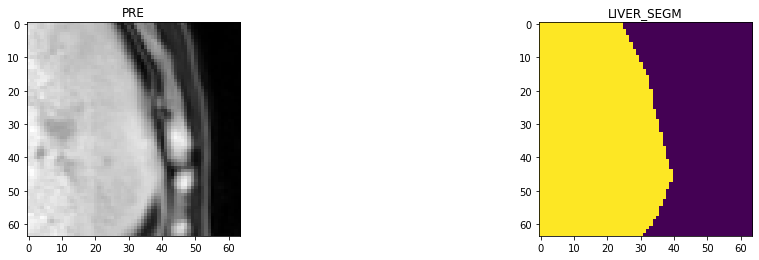

PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 0.7127623558044434
ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 0.921875


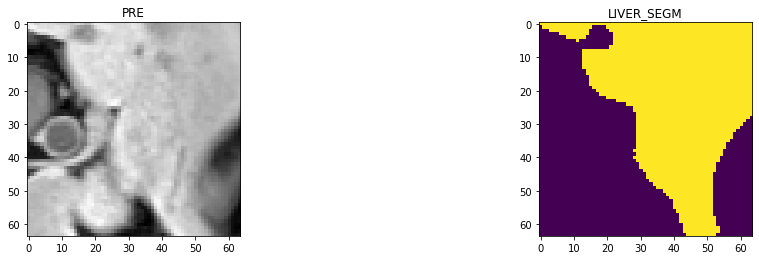

PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 0.7241694927215576
ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 0.7478968501091003


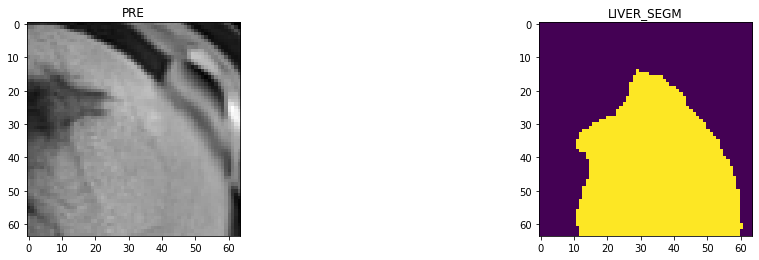

PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 0.7861292958259583
ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 0.9538607001304626


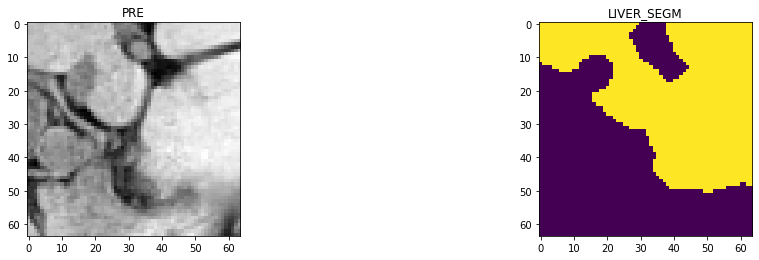

PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 0.5114307403564453
ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 0.5829825401306152


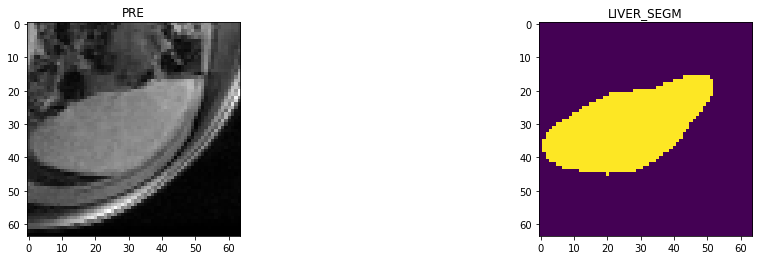

PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 0.7750706672668457
ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 0.9580510854721069


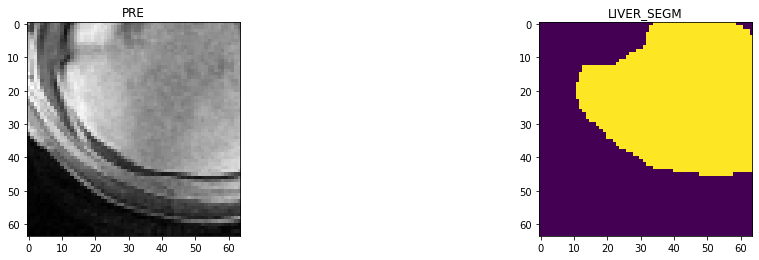

PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 0.9367546439170837
ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 1.2794605493545532


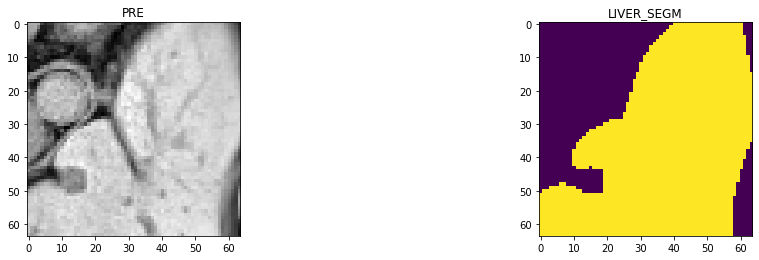

PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 0.3359646797180176
ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 0.5182024240493774


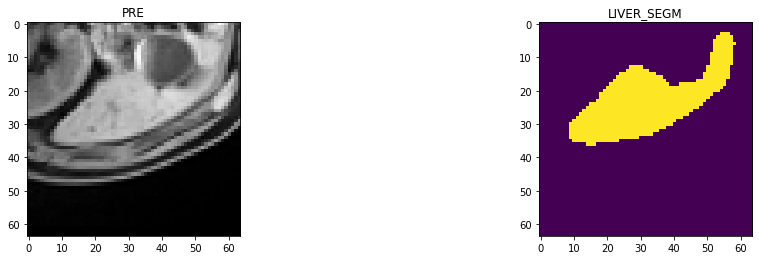

PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 0.5191205739974976
ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 0.725625216960907


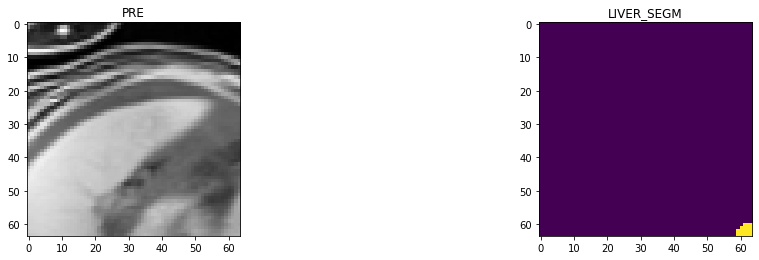

PRE shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PRE mean: 0.707071840763092
ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 0.8419103622436523


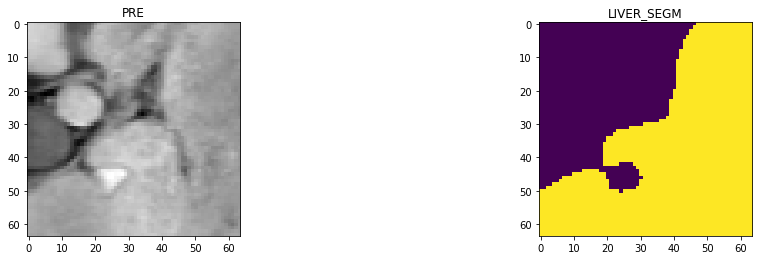

In [13]:
check_ds = monai.data.Dataset(data=train_data_dict[:10], transform=train_transforms)
#check_ds = monai.data.Dataset(data=val_data_dict[10:11], transform=val_transforms)
#check_ds = monai.data.Dataset(data=test_data_dict[:1], transform=test_transforms)

check_loader = DataLoader(check_ds, batch_size=10, num_workers=0, collate_fn=list_data_collate)
check_data = monai.utils.misc.first(check_loader)
print(check_data['PRE'].shape)
print(check_data['ART'].shape)


num_display = 10
if check_data['PRE'].shape[0] < num_display:
    num_display = check_data['PRE'].shape[0]

for i in range(num_display):
    PRE, ART, liver_label = (check_data['PRE'][i][0],check_data['ART'][i][0], check_data['SEGM'][i][0])


    
    print('PRE shape: {}, label shape: {}'.format(PRE.shape, liver_label.shape))
    print('PRE mean: {}'.format(np.mean(PRE.numpy())))
    
    
    print('ART shape: {}, label shape: {}'.format(ART.shape, liver_label.shape))
    print('ART mean: {}'.format(np.mean(ART.numpy())))
    
    slice_num = PRE.shape[2]//2
    
    plt.figure('check', (13, 15))

    plt.subplot(1, 3, 1)
    plt.title('PRE')
    plt.imshow(PRE[:,:,slice_num], cmap='gray')

 
    
    plt.subplot(1, 3, 3)
    plt.title('ART')
    plt.imshow(ART[:,:,slice_num], cmap='gray')

    plt.subplot(1, 3 ,3)
    plt.title('LIVER_SEGM')
    plt.imshow(liver_label[:,:,slice_num])
    
    plt.show()



    


## Create Segmentation Model (U-net)

In [14]:
class MRILiverSegmentation(pytorch_lightning.LightningModule):

    def __init__(self, dropout_rate = 0.0):
        super().__init__()
        
        self._model = monai.networks.nets.UNet(
            dimensions=3, 
            in_channels=2, 
            out_channels=2, 
            channels=(16, 32, 64, 128),
            strides=(2, 2, 2), 
            num_res_units=2, 
            norm=Norm.BATCH,
            dropout = dropout_rate,
        )

    
        self.loss_function = monai.losses.DiceLoss(include_background=False, to_onehot_y=True, softmax=True)
        self.one_hot_transform = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
        self.val_metric = DiceMetric(include_background=False)

        self.best_val_dice = None
        self.best_val_epoch = None
        
        
    def forward(self, x):
        return self._model(x)

    
    def prepare_data(self):
        # set deterministic training for reproducibility
        set_determinism(seed=0)
    
    
    def training_step(self, batch, batch_idx):

        pre_images =  batch["PRE"]
        art_images =  batch["ART"]
        
        
        images = torch.cat((pre_images, art_images) ,dim=1)
        labels = batch["SEGM"]

        
        
        output = self.forward(images)
        loss = self.loss_function(output, labels)
        return {"loss": loss}
    
    
    def training_epoch_end(self, outputs):
        # Only add the graph at the first epoch
        if self.current_epoch==1:
            #sample_input = torch.rand((1,1,96,96,16))
            sample_input = torch.rand((1,2,64,64,32))
            self.logger.experiment.add_graph(
                MRILiverSegmentation(), 
                [sample_input])
        
        # Calculate the average loss
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        # Logging at the end of every epoch
        self.logger.experiment.add_scalar('Train/Loss', avg_loss, self.current_epoch)
    
    

    def validation_step(self, batch, batch_idx):
        
        
        pre_images =  batch["PRE"]
        art_images =  batch["ART"]
        

        
        images = torch.cat((pre_images, art_images) ,dim=1)
        labels = batch["SEGM"]
        
        
        #images = batch["IMAGE"]
        #labels = batch["SEGM"]

        #roi_size = (256, 256, 48)
        roi_size = (224, 224, 128)
        sw_batch_size = 4
        outputs = sliding_window_inference(images, roi_size, sw_batch_size, self.forward)

        loss = self.loss_function(outputs, labels)

#         one_hot = monai.networks.utils.one_hot(labels, num_classes=3)
        argmax = torch.argmax(outputs, dim=1, keepdim=True)
        val_dice = self.val_metric(
            self.one_hot_transform(argmax), 
            self.one_hot_transform(labels)
        )
                
        if batch_idx<1:
            img2tensorboard.plot_2d_or_3d_image(data=images, 
                            step=self.current_epoch, 
                            writer=self.logger.experiment,
                            tag='Validation/Input')
            img2tensorboard.plot_2d_or_3d_image(data=argmax, 
                            step=self.current_epoch, 
                            writer=self.logger.experiment,
                            tag='Validation/Output')

        return {"val_loss": loss, "val_dice": val_dice}
    
    def validation_epoch_end(self, outputs):
        # Calculate the average loss
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_dice = torch.stack([x['val_dice'][0] for x in outputs]).mean()
        # Logging at the end of every epoch
        self.logger.experiment.add_scalar('Val/Loss', avg_loss, self.current_epoch)
        self.logger.experiment.add_scalar('Val/Dice', avg_dice, self.current_epoch)
        
        self.log('val_loss', avg_loss)
        self.log('val_dice', avg_dice)

    
    def configure_optimizers(self):
        return torch.optim.Adam(self._model.parameters(), lr=1e-4)
    
    

In [15]:
from torchinfo import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MRILiverSegmentation()
#summary(model.to(device), [1,1,96,96,16])
summary(model.to(device), [1,2,64,64,32])

Layer (type:depth-idx)                                                           Output Shape              Param #
MRILiverSegmentation                                                             --                        --
├─UNet: 1-1                                                                      [1, 2, 64, 64, 32]        --
│    └─Sequential: 2-1                                                           [1, 2, 64, 64, 32]        --
│    │    └─ResidualUnit: 3-1                                                    [1, 16, 32, 32, 16]       8,754
│    │    └─SkipConnection: 3-2                                                  [1, 32, 32, 32, 16]       1,178,186
│    │    └─Sequential: 3-3                                                      [1, 2, 64, 64, 32]        1,845
Total params: 1,188,785
Trainable params: 1,188,785
Non-trainable params: 0
Total mult-adds (G): 1.69
Input size (MB): 1.05
Forward/backward pass size (MB): 45.22
Params size (MB): 4.76
Estimated Total Size (MB):

## Model Training

In [16]:
MODEL_ROOT_PATH = r'/tensor5/data1/mgross/Liver/studies/Contrast-Nets/PRE-ART-Net/'


In [ ]:
# initialise the LightningModule
model = MRILiverSegmentation(dropout_rate=0.3)

# set up loggers and checkpoints
tb_logger = pytorch_lightning.loggers.TensorBoardLogger(
    save_dir=os.path.join(MODEL_ROOT_PATH,'saved_model','logs')
)

lr_monitor = pytorch_lightning.callbacks.LearningRateMonitor(logging_interval='epoch')

checkpoint_callback = pytorch_lightning.callbacks.ModelCheckpoint(
    dirpath=os.path.join(MODEL_ROOT_PATH,'saved_model'),
    filename="MRILiverSegmentation-{epoch:04d}-{val_loss:.2f}",
    monitor='val_loss',
    save_last=True,
    save_on_train_epoch_end=True,
    save_top_k=2,
    mode='min'
)

# check for last checkpoint
resume_checkpoint = None
if os.path.exists(os.path.join(MODEL_ROOT_PATH,'saved_model','last.ckpt')):
    resume_checkpoint = os.path.join(MODEL_ROOT_PATH,'saved_model','last.ckpt')

# initialise Lightning's trainer.
trainer = pytorch_lightning.Trainer(
    gpus=[0],
    max_epochs=2000,
    logger=tb_logger,
    callbacks=[lr_monitor,checkpoint_callback],
    num_sanity_val_steps=1,
    check_val_every_n_epoch=20,
    resume_from_checkpoint=resume_checkpoint
)

# train
trainer.fit(model, train_dataloader=train_loader, val_dataloaders=val_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:730: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type     | Params
-------------------------------------------
0 | _model        | UNet     | 1.2 M 
1 | loss_function | DiceLoss | 0     
-------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.755     Total estimated model params size (MB)
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /data1/mgross/Liver/studies/Contrast-Nets/PRE-ART-

Validation sanity check: 0it [00:00, ?it/s]

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:56: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 7. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:393: UserWarning: The number of training samples (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:56: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 8. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:56: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 10. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/torch/_jit_internal.py:603: LightningDeprecationWarning: The `LightningModule.loaded_optimizer_states_dict` property is deprecated in v1.4 and will be removed in v1.6.
  if hasattr(mod, name):
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/torch/_jit_internal.py:603: LightningDeprecati

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

## Model Testing

In [17]:
model_path = os.path.join(MODEL_ROOT_PATH,'saved_model','MRILiverSegmentation-epoch=0880-val_loss=0.07.ckpt')

In [18]:
model = MRILiverSegmentation.load_from_checkpoint(model_path)
# model.load_from_checkpoint(model_path)
model.eval()
device = torch.device("cuda:0")
model.to(device)

MRILiverSegmentation(
  (_model): UNet(
    (model): Sequential(
      (0): ResidualUnit(
        (conv): Sequential(
          (unit0): Convolution(
            (conv): Conv3d(2, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
            (adn): ADN(
              (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (D): Dropout(p=0.0, inplace=False)
              (A): PReLU(num_parameters=1)
            )
          )
          (unit1): Convolution(
            (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (adn): ADN(
              (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (D): Dropout(p=0.0, inplace=False)
              (A): PReLU(num_parameters=1)
            )
          )
        )
        (residual): Conv3d(2, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      )
      (1): SkipConnection(
        

In [19]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import torch
import time


from monai.transforms import KeepLargestConnectedComponent
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.metrics import compute_meandice
from monai.metrics import compute_hausdorff_distance
from monai.metrics import compute_average_surface_distance


from monai.data import write_nifti
from tqdm.notebook import tqdm
from monai.data import decollate_batch




def compute_evaluation_metrics(y_pred, y, keep=False):
    
    argmax = monai.transforms.AsDiscrete(argmax=True)
    one_hot = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
    dice = monai.metrics.DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
    hd = monai.metrics.HausdorffDistanceMetric(include_background=False, reduction="mean", percentile=95, get_not_nans=False)
    mad = monai.metrics.SurfaceDistanceMetric(include_background=False, reduction="mean", get_not_nans=False)
    keep_largest = monai.transforms.KeepLargestConnectedComponent(applied_labels=[1])

    dice_list = list()
    hd_list = list()
    mad_list = list()
    for y_pred_i, y_i in decollate_batch((y_pred, y)):
        print(y_pred_i.shape)
        print(y_i.shape)
        if keep:
            #dice(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            #hd(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            #mad(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            y_pred_i_proc=one_hot(keep_largest(argmax(y_pred_i)))
        else:
                
            # Calculate Dice on the raw output
            #dice(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            #hd(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            #mad(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            y_pred_i_proc = one_hot(argmax(y_pred_i))
        y_pred_i_proc = monai.transforms.AddChannel()(y_pred_i_proc)
        y_i_proc = monai.transforms.AddChannel()(one_hot(y_i))
        print(y_pred_i_proc.shape)
            
        #dice(y_pred=y_pred_i_proc, y=one_hot(y_i))
        #hd(y_pred=y_pred_i_proc, y=one_hot(y_i))
        #mad(y_pred=y_pred_i_proc, y=one_hot(y_i))
            
        dice(y_pred=y_pred_i_proc, y=y_i_proc)
        hd(y_pred=y_pred_i_proc, y=y_i_proc)
        mad(y_pred=y_pred_i_proc, y=y_i_proc)
        
        dice_value = dice.aggregate().item()
        hd_value = hd.aggregate().item()
        mad_value = mad.aggregate().item()
        
        print(dice_value)
        print(hd_value)
        print(mad_value)
        
        dice_list.append(dice_value)
        hd_list.append(hd_value)
        mad_list.append(mad_value)
              
    return dice_list, hd_list, mad_list


def run_inference_and_evaluate(model, data_loader, plot_images=False, max_eval=None, 
                               save_output=False,roi_size=(224,224,128), sw_batch_size=4, output_path=None):
    
    """Inference and evaluation function for Liver segmentation.
    
    """   
    
    df_eval = pd.DataFrame()
    
    acc_ids = list()
    input_paths = list()
    output_paths = list()
    
    original_dice_results = list()
    postprocess_dice_results = list()

    original_hd_results = list()
    postprocess_hd_results = list()

    original_mad_results = list()
    postprocess_mad_results = list()
    
    inference_times = list()
    


    
    # Use MONAI one_hot transform
    argmax = monai.transforms.AsDiscrete(argmax=True)
    one_hot = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
    dice = monai.metrics.DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
    keep = monai.transforms.KeepLargestConnectedComponent(applied_labels=[1])

    with torch.no_grad():
        for i, test_data in tqdm(enumerate(data_loader)):
        # Early stopping
            if max_eval is not None:
                if i>=max_eval:
                    break

            #print(test_data['ACCESSION_ID'][0])
            #for val in test_data['ACCESSION_ID'][0]:
            #    acc_ids.append(val)

    
            pre_images =  test_data["PRE"].to(device)
            art_images =  test_data["ART"].to(device)
            
            x = torch.cat((pre_images, art_images) ,dim=1)
            y = test_data['SEGM'].cpu()




            start_time = time.time()
            y_pred = sliding_window_inference(x, roi_size, sw_batch_size, model)
            stop_time = time.time()

            inference_time = stop_time-start_time
            inference_times.append(inference_time)

            x = x.detach().cpu()
            y_pred = y_pred.detach().cpu()
            #print(y_pred.shape)

            #argmax = torch.argmax(y_pred, dim=1, keepdim=True)
            #argmax = argmax.detach().cpu()

            #y_onehot = one_hot(y)
            #y_pred_onehot = one_hot(argmax)

            # Evaluate segmentation metrics
            eval_list = list()
            # Update to MONAI 0.7+
            dice_values, hd_values, mad_values = compute_evaluation_metrics(
                y_pred=y_pred, y=y
            )

            for val in dice_values:
                original_dice_results.append(val)
            for val in hd_values:
                original_hd_results.append(val)
            for val in mad_values:
                original_mad_results.append(val)



            post_dice_values, post_hd_values, post_mad_values = compute_evaluation_metrics(
                y_pred=y_pred, y=y, keep=True
            )        #dice_list = list()
            #post_dice_list = list()

            for val in post_dice_values:
                postprocess_dice_results.append(val)
            for val in post_hd_values:
                postprocess_hd_results.append(val)
            for val in post_mad_values:
                postprocess_mad_results.append(val)





            print(y_pred.shape)
            print(argmax(y_pred[0,...]).shape)


            if plot_images:
                pre_img = pre_images.detach().cpu()
                art_img = art_images.detach().cpu()
                


                slice_num = x.shape[-1]//2

                plt.figure('check', (9, 3))
                plt.subplot(1, 4, 1)
                plt.title('PRE')
                plt.imshow(pre_img[0,0,:,:,slice_num], cmap='gray')

                plt.subplot(1, 4, 2)
                plt.title('ART')
                plt.imshow(art_img[0,0,:,:,slice_num], cmap='gray')

            
                plt.subplot(1, 4, 3)
                plt.title('SEGM')
                plt.imshow(y[0,0,:,:,slice_num])

                plt.subplot(1, 4, 4)
                plt.title('PRED')
                #plt.imshow(argmax(y_pred[0,...])[0,:,:,slice_num])
                plt.imshow(keep(argmax(y_pred[0,...]))[0,:,:,slice_num])
                plt.show()


            # Write data out
            if save_output:
                # Get the image affine matrix
                current_affine = test_data['PRE_meta_dict']['affine'][0].numpy()
                original_affine = test_data['PRE_meta_dict']['original_affine'][0].numpy()
                original_spatial_shape = test_data['PRE_meta_dict']['spatial_shape'][0].numpy()

                input_file_name = test_data['PRE_meta_dict']['filename_or_obj'][0]
                output_file_name = os.path.split(input_file_name)[1]
                output_root_name = output_file_name[:-len('.nii.gz')]
                output_path_final = os.path.join(output_path,'{}_segm.nii.gz'.format(output_root_name))
                print('Saving segmentation results: {}'.format(output_path_final))
                
                output_paths.append(output_path_final)
                
                #output_segm = argmax.cpu()[0, 0,...].numpy()
                output_segm = keep(argmax(y_pred[0,...])).cpu()[0,...].numpy()
                write_nifti(output_segm, output_path_final,
                            mode='nearest',
                            affine=current_affine, 
                            target_affine=original_affine,
                            output_spatial_shape=original_spatial_shape, 
                            dtype=np.float32
                           )

    
    #df_eval['ACCESSION_ID'] = acc_ids
    #df_eval['PV'] = input_paths
    df_eval['DICE'] = original_dice_results
    print(original_dice_results)
    df_eval['POST_DICE'] = postprocess_dice_results
    df_eval['HD95'] = original_hd_results
    df_eval['POST_HD95'] = postprocess_hd_results
    #df_eval['MAD'] = original_mad_results
    #df_eval['POST_MAD'] = postprocess_mad_results
    df_eval['InferenceTime'] = inference_times
    if output_path is not None:
        df_eval['AUTOMATED-LIVER-SEGM'] = output_paths    
    return df_eval


In [20]:
OUTPUT_PATH = r'/tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART'

0it [00:00, ?it/s]

torch.Size([2, 201, 151, 108])
torch.Size([1, 201, 151, 108])
torch.Size([1, 2, 201, 151, 108])
0.9271154403686523
72.4568837309472
15.905949671722121
torch.Size([2, 201, 151, 108])
torch.Size([1, 201, 151, 108])
torch.Size([1, 2, 201, 151, 108])
0.9644954204559326
1.4142135623730951
0.5306388252569224
torch.Size([1, 2, 201, 151, 108])
torch.Size([1, 201, 151, 108])


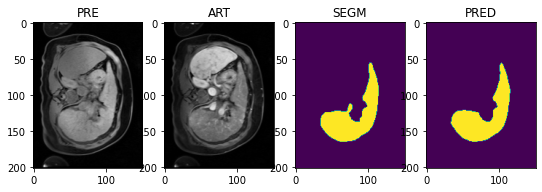

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E100998852_T1_PRE_REG_segm.nii.gz
torch.Size([2, 190, 143, 120])
torch.Size([1, 190, 143, 120])
torch.Size([1, 2, 190, 143, 120])
0.900335967540741
78.7273777030583
24.164107089194847
torch.Size([2, 190, 143, 120])
torch.Size([1, 190, 143, 120])
torch.Size([1, 2, 190, 143, 120])
0.9743906259536743
1.4142135623730951
0.4524304650491887
torch.Size([1, 2, 190, 143, 120])
torch.Size([1, 190, 143, 120])


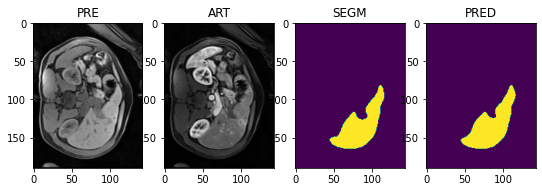

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/12370686_T1_PRE_REG_segm.nii.gz
torch.Size([2, 220, 177, 120])
torch.Size([1, 220, 177, 120])
torch.Size([1, 2, 220, 177, 120])
0.9385819435119629
75.31599737183686
14.437686708439804
torch.Size([2, 220, 177, 120])
torch.Size([1, 220, 177, 120])
torch.Size([1, 2, 220, 177, 120])
0.9678361415863037
1.4142135623730951
0.49278637472249354
torch.Size([1, 2, 220, 177, 120])
torch.Size([1, 220, 177, 120])


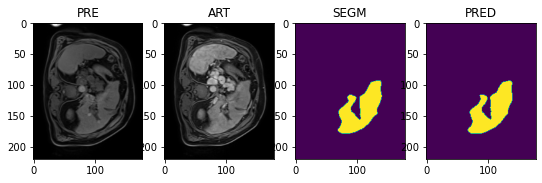

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E104184251_T1_PRE_REG_segm.nii.gz
torch.Size([2, 230, 230, 144])
torch.Size([1, 230, 230, 144])
torch.Size([1, 2, 230, 230, 144])
0.7491883635520935
79.7370679169983
28.626482023775505
torch.Size([2, 230, 230, 144])
torch.Size([1, 230, 230, 144])
torch.Size([1, 2, 230, 230, 144])
0.9356977343559265
3.605551275463989
1.0552317746037245
torch.Size([1, 2, 230, 230, 144])
torch.Size([1, 230, 230, 144])


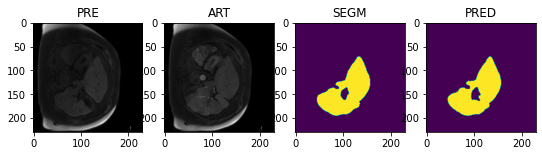

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E100353838_T1_PRE_REG_segm.nii.gz
torch.Size([2, 210, 158, 95])
torch.Size([1, 210, 158, 95])
torch.Size([1, 2, 210, 158, 95])
0.8352509140968323
84.97676151958017
31.050728292672247
torch.Size([2, 210, 158, 95])
torch.Size([1, 210, 158, 95])
torch.Size([1, 2, 210, 158, 95])
0.8943102359771729
50.73460357586329
15.255249927522666
torch.Size([1, 2, 210, 158, 95])
torch.Size([1, 210, 158, 95])


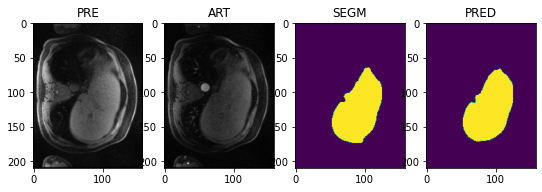

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/11655071_T1_PRE_REG_segm.nii.gz
torch.Size([2, 190, 149, 120])
torch.Size([1, 190, 149, 120])
torch.Size([1, 2, 190, 149, 120])
0.8687925338745117
99.48643120420202
28.125138966328667
torch.Size([2, 190, 149, 120])
torch.Size([1, 190, 149, 120])
torch.Size([1, 2, 190, 149, 120])
0.9628821611404419
1.4142135623730951
0.4651477698521006
torch.Size([1, 2, 190, 149, 120])
torch.Size([1, 190, 149, 120])


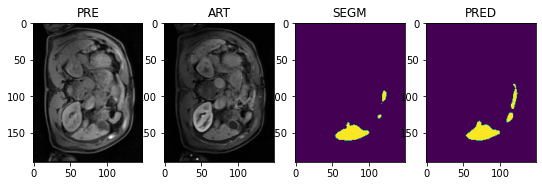

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E105258820_T1_PRE_REG_segm.nii.gz
torch.Size([2, 180, 169, 140])
torch.Size([1, 180, 169, 140])
torch.Size([1, 2, 180, 169, 140])
0.8580420613288879
69.81403870282824
14.763306825205818
torch.Size([2, 180, 169, 140])
torch.Size([1, 180, 169, 140])
torch.Size([1, 2, 180, 169, 140])
0.9278611540794373
5.744562646538029
1.3795883254675543
torch.Size([1, 2, 180, 169, 140])
torch.Size([1, 180, 169, 140])


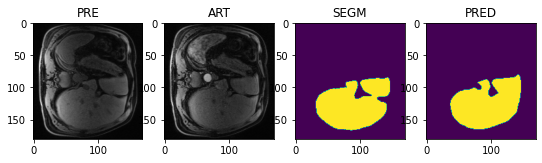

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/10782833_T1_PRE_REG_segm.nii.gz
torch.Size([2, 190, 149, 120])
torch.Size([1, 190, 149, 120])
torch.Size([1, 2, 190, 149, 120])
0.949665904045105
91.97282207261013
15.37410037376667
torch.Size([2, 190, 149, 120])
torch.Size([1, 190, 149, 120])
torch.Size([1, 2, 190, 149, 120])
0.9737222194671631
1.4142135623730951
0.4317821811822301
torch.Size([1, 2, 190, 149, 120])
torch.Size([1, 190, 149, 120])


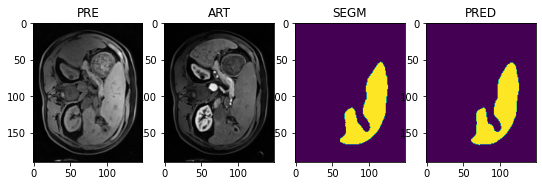

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E105047582_T1_PRE_REG_segm.nii.gz
torch.Size([2, 200, 156, 120])
torch.Size([1, 200, 156, 120])
torch.Size([1, 2, 200, 156, 120])
0.909900963306427
110.3829693440439
26.48318958582423
torch.Size([2, 200, 156, 120])
torch.Size([1, 200, 156, 120])
torch.Size([1, 2, 200, 156, 120])
0.9591884613037109
1.7320508075688772
0.5994832615891174
torch.Size([1, 2, 200, 156, 120])
torch.Size([1, 200, 156, 120])


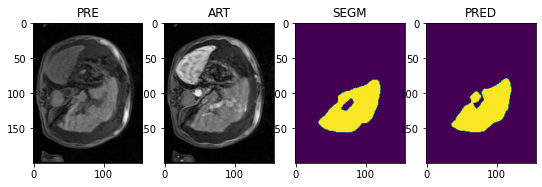

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E100559269_T1_PRE_REG_segm.nii.gz
torch.Size([2, 180, 147, 132])
torch.Size([1, 180, 147, 132])
torch.Size([1, 2, 180, 147, 132])
0.8755887150764465
61.0810935885126
13.02849068625534
torch.Size([2, 180, 147, 132])
torch.Size([1, 180, 147, 132])
torch.Size([1, 2, 180, 147, 132])
0.939152717590332
3.0
0.8785196532149743
torch.Size([1, 2, 180, 147, 132])
torch.Size([1, 180, 147, 132])


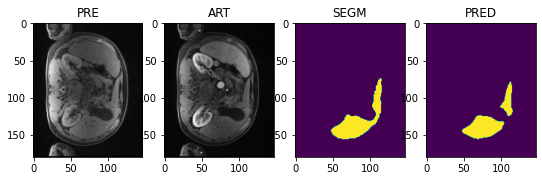

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/11157922_T1_PRE_REG_segm.nii.gz
torch.Size([2, 203, 172, 116])
torch.Size([1, 203, 172, 116])
torch.Size([1, 2, 203, 172, 116])
0.9245312213897705
76.50816887062751
19.96457824457354
torch.Size([2, 203, 172, 116])
torch.Size([1, 203, 172, 116])
torch.Size([1, 2, 203, 172, 116])
0.9691166877746582
1.4142135623730951
0.5134459156187983
torch.Size([1, 2, 203, 172, 116])
torch.Size([1, 203, 172, 116])


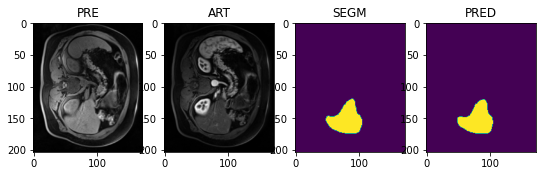

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E103977998_T1_PRE_REG_segm.nii.gz
torch.Size([2, 190, 155, 120])
torch.Size([1, 190, 155, 120])
torch.Size([1, 2, 190, 155, 120])
0.9334313869476318
94.66467112832997
23.290658942960057
torch.Size([2, 190, 155, 120])
torch.Size([1, 190, 155, 120])
torch.Size([1, 2, 190, 155, 120])
0.9569148421287537
2.449489742783178
0.7001122409279475
torch.Size([1, 2, 190, 155, 120])
torch.Size([1, 190, 155, 120])


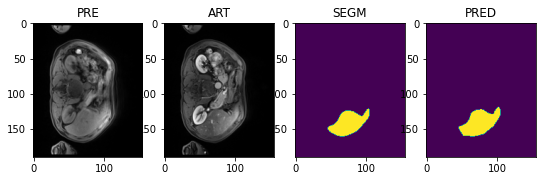

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E106605970_T1_PRE_REG_segm.nii.gz
torch.Size([2, 200, 163, 120])
torch.Size([1, 200, 163, 120])
torch.Size([1, 2, 200, 163, 120])
0.8009957671165466
77.93202159652355
29.13914890316237
torch.Size([2, 200, 163, 120])
torch.Size([1, 200, 163, 120])
torch.Size([1, 2, 200, 163, 120])
0.9505597949028015
4.47213595499958
0.7370726798519845
torch.Size([1, 2, 200, 163, 120])
torch.Size([1, 200, 163, 120])


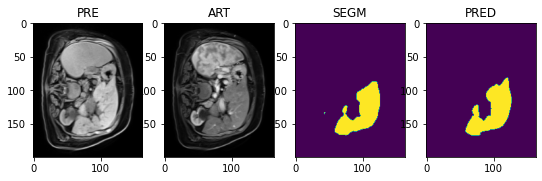

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E101166449_T1_PRE_REG_segm.nii.gz
torch.Size([2, 221, 221, 110])
torch.Size([1, 221, 221, 110])
torch.Size([1, 2, 221, 221, 110])
0.8650360107421875
132.43866504914644
57.03704235422149
torch.Size([2, 221, 221, 110])
torch.Size([1, 221, 221, 110])
torch.Size([1, 2, 221, 221, 110])
0.9708628058433533
2.0
0.481416239530074
torch.Size([1, 2, 221, 221, 110])
torch.Size([1, 221, 221, 110])


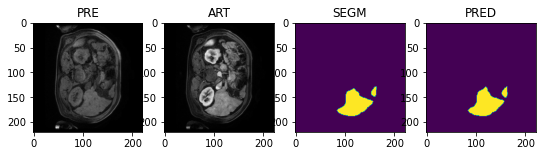

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E101693803_T1_PRE_REG_segm.nii.gz
torch.Size([2, 205, 160, 120])
torch.Size([1, 205, 160, 120])
torch.Size([1, 2, 205, 160, 120])
0.9500527381896973
66.37243364796969
8.546514557511316
torch.Size([2, 205, 160, 120])
torch.Size([1, 205, 160, 120])
torch.Size([1, 2, 205, 160, 120])
0.9619001150131226
1.4142135623730951
0.6077322380918396
torch.Size([1, 2, 205, 160, 120])
torch.Size([1, 205, 160, 120])


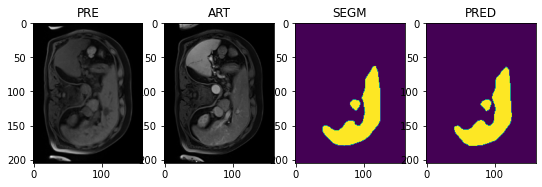

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E100488381_T1_PRE_REG_segm.nii.gz
torch.Size([2, 225, 176, 132])
torch.Size([1, 225, 176, 132])
torch.Size([1, 2, 225, 176, 132])
0.9472425580024719
7.0
2.763685649699688
torch.Size([2, 225, 176, 132])
torch.Size([1, 225, 176, 132])
torch.Size([1, 2, 225, 176, 132])
0.9497589468955994
5.656854249492381
0.9446138343307937
torch.Size([1, 2, 225, 176, 132])
torch.Size([1, 225, 176, 132])


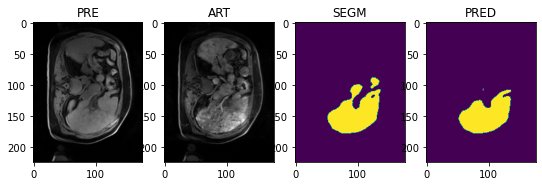

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E101446184_T1_PRE_REG_segm.nii.gz
torch.Size([2, 190, 127, 108])
torch.Size([1, 190, 127, 108])
torch.Size([1, 2, 190, 127, 108])
0.9107709527015686
72.86288492778748
14.009481651539515
torch.Size([2, 190, 127, 108])
torch.Size([1, 190, 127, 108])
torch.Size([1, 2, 190, 127, 108])
0.9428961873054504
4.58257569495584
1.2173965461308918
torch.Size([1, 2, 190, 127, 108])
torch.Size([1, 190, 127, 108])


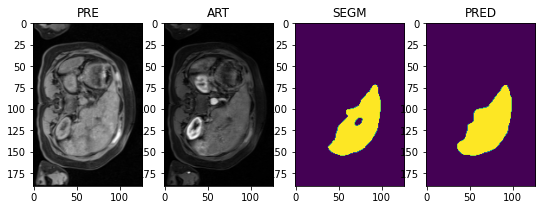

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/12132879_T1_PRE_REG_segm.nii.gz
torch.Size([2, 250, 187, 132])
torch.Size([1, 250, 187, 132])
torch.Size([1, 2, 250, 187, 132])
0.9559006094932556
135.08238210930708
25.954624552752385
torch.Size([2, 250, 187, 132])
torch.Size([1, 250, 187, 132])
torch.Size([1, 2, 250, 187, 132])
0.971661388874054
1.4142135623730951
0.5134684577640644
torch.Size([1, 2, 250, 187, 132])
torch.Size([1, 250, 187, 132])


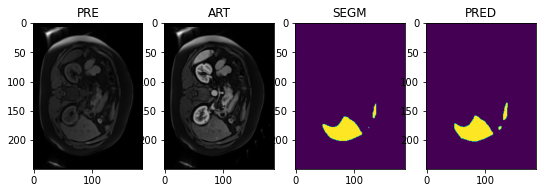

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E100207522_T1_PRE_REG_segm.nii.gz
torch.Size([2, 210, 169, 120])
torch.Size([1, 210, 169, 120])
torch.Size([1, 2, 210, 169, 120])
0.9003240466117859
74.4983221287567
18.87770939967388
torch.Size([2, 210, 169, 120])
torch.Size([1, 210, 169, 120])
torch.Size([1, 2, 210, 169, 120])
0.9679110050201416
1.7320508075688772
0.5910767726006518
torch.Size([1, 2, 210, 169, 120])
torch.Size([1, 210, 169, 120])


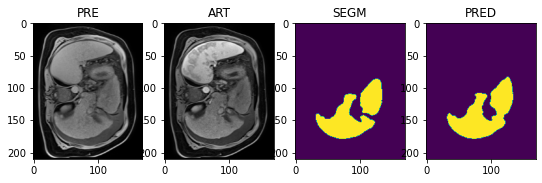

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E104350920_T1_PRE_REG_segm.nii.gz
torch.Size([2, 190, 143, 120])
torch.Size([1, 190, 143, 120])
torch.Size([1, 2, 190, 143, 120])
0.8727530241012573
62.75348595894893
22.12813146790539
torch.Size([2, 190, 143, 120])
torch.Size([1, 190, 143, 120])
torch.Size([1, 2, 190, 143, 120])
0.9547405242919922
2.0
0.7234338098071882
torch.Size([1, 2, 190, 143, 120])
torch.Size([1, 190, 143, 120])


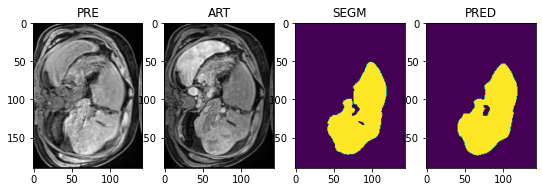

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E103442524_T1_PRE_REG_segm.nii.gz
torch.Size([2, 210, 210, 132])
torch.Size([1, 210, 210, 132])
torch.Size([1, 2, 210, 210, 132])
0.8671876192092896
66.49060083951716
18.102411728418613
torch.Size([2, 210, 210, 132])
torch.Size([1, 210, 210, 132])
torch.Size([1, 2, 210, 210, 132])
0.9715533256530762
2.0
0.5640571878254284
torch.Size([1, 2, 210, 210, 132])
torch.Size([1, 210, 210, 132])


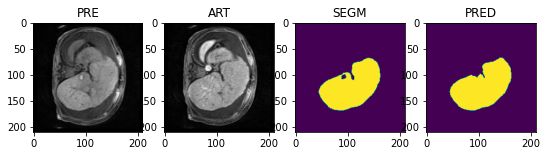

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E100354995_T1_PRE_REG_segm.nii.gz
torch.Size([2, 200, 157, 120])
torch.Size([1, 200, 157, 120])
torch.Size([1, 2, 200, 157, 120])
0.8902854919433594
67.67569726275453
21.89571548041761
torch.Size([2, 200, 157, 120])
torch.Size([1, 200, 157, 120])
torch.Size([1, 2, 200, 157, 120])
0.9705424904823303
1.4142135623730951
0.5255827064780455
torch.Size([1, 2, 200, 157, 120])
torch.Size([1, 200, 157, 120])


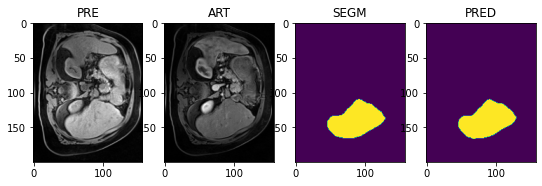

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/12169194_T1_PRE_REG_segm.nii.gz
torch.Size([2, 191, 191, 88])
torch.Size([1, 191, 191, 88])
torch.Size([1, 2, 191, 191, 88])
0.5413159728050232
117.2433366976563
55.868936712774584
torch.Size([2, 191, 191, 88])
torch.Size([1, 191, 191, 88])
torch.Size([1, 2, 191, 191, 88])
0.964098334312439
1.4142135623730951
0.5690601064589329
torch.Size([1, 2, 191, 191, 88])
torch.Size([1, 191, 191, 88])


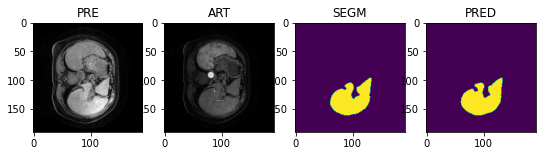

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/9464709_T1_PRE_REG_segm.nii.gz
torch.Size([2, 221, 221, 144])
torch.Size([1, 221, 221, 144])
torch.Size([1, 2, 221, 221, 144])
0.8305402994155884
124.8861481351425
43.03394695216757
torch.Size([2, 221, 221, 144])
torch.Size([1, 221, 221, 144])
torch.Size([1, 2, 221, 221, 144])
0.9715585708618164
1.4142135623730951
0.5079351806488044
torch.Size([1, 2, 221, 221, 144])
torch.Size([1, 221, 221, 144])


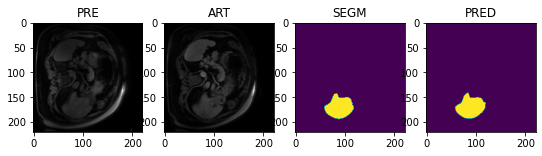

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E102885531_T1_PRE_REG_segm.nii.gz
torch.Size([2, 200, 163, 108])
torch.Size([1, 200, 163, 108])
torch.Size([1, 2, 200, 163, 108])
0.9256715774536133
68.2440461053671
18.726303951221034
torch.Size([2, 200, 163, 108])
torch.Size([1, 200, 163, 108])
torch.Size([1, 2, 200, 163, 108])
0.9578689336776733
2.0
0.684550917584867
torch.Size([1, 2, 200, 163, 108])
torch.Size([1, 200, 163, 108])


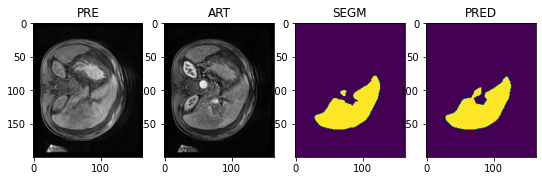

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E106731917_T1_PRE_REG_segm.nii.gz
torch.Size([2, 211, 211, 131])
torch.Size([1, 211, 211, 131])
torch.Size([1, 2, 211, 211, 131])
0.9222959876060486
138.65568865675561
25.80985495406335
torch.Size([2, 211, 211, 131])
torch.Size([1, 211, 211, 131])
torch.Size([1, 2, 211, 211, 131])
0.9424462914466858
6.782329983125268
0.7229712412045707
torch.Size([1, 2, 211, 211, 131])
torch.Size([1, 211, 211, 131])


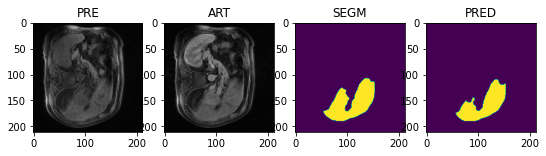

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E105877173_T1_PRE_REG_segm.nii.gz
torch.Size([2, 175, 143, 108])
torch.Size([1, 175, 143, 108])
torch.Size([1, 2, 175, 143, 108])
0.9072135090827942
91.97553922264554
23.26689571611065
torch.Size([2, 175, 143, 108])
torch.Size([1, 175, 143, 108])
torch.Size([1, 2, 175, 143, 108])
0.9619190096855164
2.0
0.6070925734170008
torch.Size([1, 2, 175, 143, 108])
torch.Size([1, 175, 143, 108])


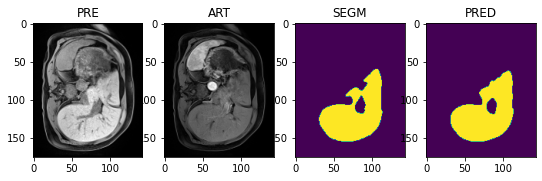

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E106096969_T1_PRE_REG_segm.nii.gz
torch.Size([2, 190, 184, 120])
torch.Size([1, 190, 184, 120])
torch.Size([1, 2, 190, 184, 120])
0.9276397824287415
80.18665474895971
20.235945009650507
torch.Size([2, 190, 184, 120])
torch.Size([1, 190, 184, 120])
torch.Size([1, 2, 190, 184, 120])
0.9628861546516418
2.0
0.635557375890521
torch.Size([1, 2, 190, 184, 120])
torch.Size([1, 190, 184, 120])


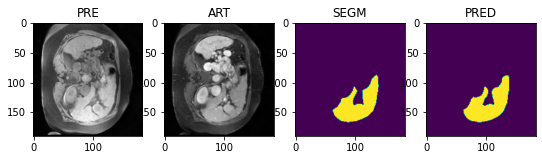

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/11571840_T1_PRE_REG_segm.nii.gz
torch.Size([2, 220, 165, 131])
torch.Size([1, 220, 165, 131])
torch.Size([1, 2, 220, 165, 131])
0.9668298363685608
1.4142135623730951
0.5691457805422181
torch.Size([2, 220, 165, 131])
torch.Size([1, 220, 165, 131])
torch.Size([1, 2, 220, 165, 131])
0.9668298363685608
1.4142135623730951
0.5691457805422181
torch.Size([1, 2, 220, 165, 131])
torch.Size([1, 220, 165, 131])


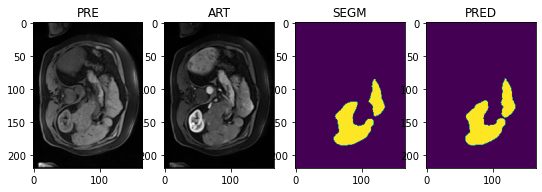

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E101753253_T1_PRE_REG_segm.nii.gz
torch.Size([2, 190, 155, 120])
torch.Size([1, 190, 155, 120])
torch.Size([1, 2, 190, 155, 120])
0.9562997221946716
61.54673021371647
11.402340531543325
torch.Size([2, 190, 155, 120])
torch.Size([1, 190, 155, 120])
torch.Size([1, 2, 190, 155, 120])
0.9734768867492676
1.4142135623730951
0.45543983344657557
torch.Size([1, 2, 190, 155, 120])
torch.Size([1, 190, 155, 120])


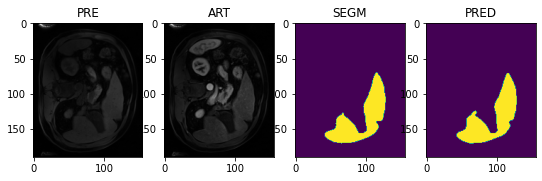

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E103922902_T1_PRE_REG_segm.nii.gz
torch.Size([2, 210, 164, 120])
torch.Size([1, 210, 164, 120])
torch.Size([1, 2, 210, 164, 120])
0.9039607048034668
94.07071804800609
22.842595206777677
torch.Size([2, 210, 164, 120])
torch.Size([1, 210, 164, 120])
torch.Size([1, 2, 210, 164, 120])
0.9631906151771545
2.23606797749979
0.6832367714647875
torch.Size([1, 2, 210, 164, 120])
torch.Size([1, 210, 164, 120])


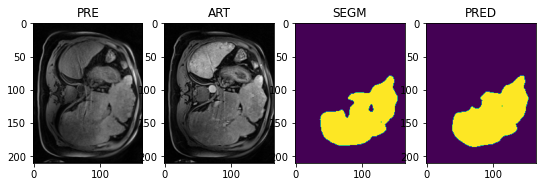

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E101453378_T1_PRE_REG_segm.nii.gz
torch.Size([2, 180, 146, 102])
torch.Size([1, 180, 146, 102])
torch.Size([1, 2, 180, 146, 102])
0.8002381324768066
80.90117428072351
29.100228708272613
torch.Size([2, 180, 146, 102])
torch.Size([1, 180, 146, 102])
torch.Size([1, 2, 180, 146, 102])
0.9532540440559387
3.605551275463989
0.9236154192267785
torch.Size([1, 2, 180, 146, 102])
torch.Size([1, 180, 146, 102])


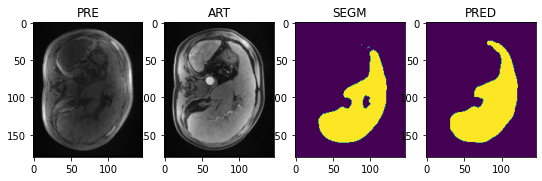

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/11397044_T1_PRE_REG_segm.nii.gz
torch.Size([2, 210, 158, 120])
torch.Size([1, 210, 158, 120])
torch.Size([1, 2, 210, 158, 120])
0.9276695847511292
81.06509702910948
18.41463197309384
torch.Size([2, 210, 158, 120])
torch.Size([1, 210, 158, 120])
torch.Size([1, 2, 210, 158, 120])
0.9712422490119934
1.4142135623730951
0.4672574580922613
torch.Size([1, 2, 210, 158, 120])
torch.Size([1, 210, 158, 120])


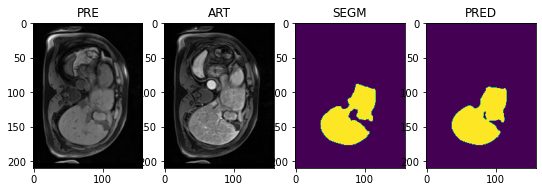

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/12922235_T1_PRE_REG_segm.nii.gz
torch.Size([2, 185, 151, 120])
torch.Size([1, 185, 151, 120])
torch.Size([1, 2, 185, 151, 120])
0.9292809367179871
62.3377895020348
14.779370038952262
torch.Size([2, 185, 151, 120])
torch.Size([1, 185, 151, 120])
torch.Size([1, 2, 185, 151, 120])
0.9615577459335327
2.449489742783178
0.567539619032248
torch.Size([1, 2, 185, 151, 120])
torch.Size([1, 185, 151, 120])


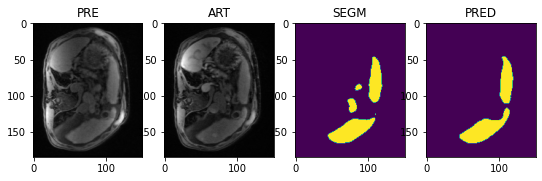

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/10939089_T1_PRE_REG_segm.nii.gz
torch.Size([2, 225, 149, 144])
torch.Size([1, 225, 149, 144])
torch.Size([1, 2, 225, 149, 144])
0.9686000347137451
2.449489742783178
1.8507432479643435
torch.Size([2, 225, 149, 144])
torch.Size([1, 225, 149, 144])
torch.Size([1, 2, 225, 149, 144])
0.9738120436668396
1.4142135623730951
0.4262796895180248
torch.Size([1, 2, 225, 149, 144])
torch.Size([1, 225, 149, 144])


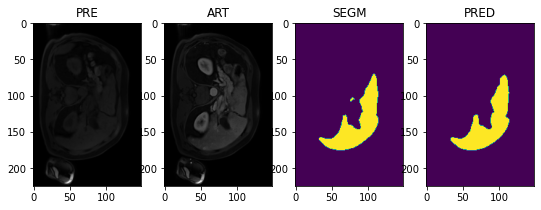

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/12957044_T1_PRE_REG_segm.nii.gz
torch.Size([2, 220, 179, 120])
torch.Size([1, 220, 179, 120])
torch.Size([1, 2, 220, 179, 120])
0.9415494203567505
56.61271941887264
9.820645284686204
torch.Size([2, 220, 179, 120])
torch.Size([1, 220, 179, 120])
torch.Size([1, 2, 220, 179, 120])
0.9549763798713684
2.8284271247461903
0.8447977866800563
torch.Size([1, 2, 220, 179, 120])
torch.Size([1, 220, 179, 120])


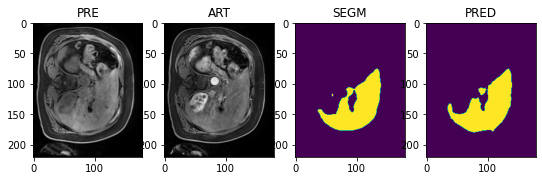

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E107891018_T1_PRE_REG_segm.nii.gz
torch.Size([2, 201, 151, 132])
torch.Size([1, 201, 151, 132])
torch.Size([1, 2, 201, 151, 132])
0.967158317565918
2.0
2.717721725257231
torch.Size([2, 201, 151, 132])
torch.Size([1, 201, 151, 132])
torch.Size([1, 2, 201, 151, 132])
0.9689078330993652
1.4142135623730951
0.5359575282858619
torch.Size([1, 2, 201, 151, 132])
torch.Size([1, 201, 151, 132])


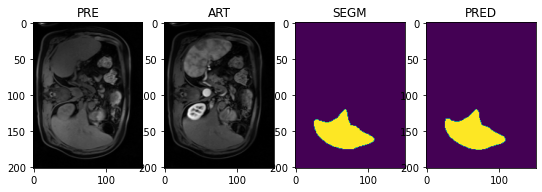

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E104332583_T1_PRE_REG_segm.nii.gz
torch.Size([2, 220, 165, 144])
torch.Size([1, 220, 165, 144])
torch.Size([1, 2, 220, 165, 144])
0.9742562174797058
1.4142135623730951
1.4555629860892116
torch.Size([2, 220, 165, 144])
torch.Size([1, 220, 165, 144])
torch.Size([1, 2, 220, 165, 144])
0.9751196503639221
1.4142135623730951
0.49268912503780615
torch.Size([1, 2, 220, 165, 144])
torch.Size([1, 220, 165, 144])


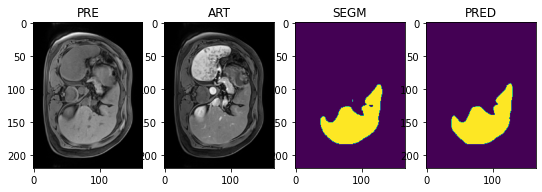

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E101547088_T1_PRE_REG_segm.nii.gz
torch.Size([2, 195, 147, 139])
torch.Size([1, 195, 147, 139])
torch.Size([1, 2, 195, 147, 139])
0.9638040065765381
90.2258276329734
8.497122029094253
torch.Size([2, 195, 147, 139])
torch.Size([1, 195, 147, 139])
torch.Size([1, 2, 195, 147, 139])
0.9686488509178162
1.7320508075688772
0.5326673353733339
torch.Size([1, 2, 195, 147, 139])
torch.Size([1, 195, 147, 139])


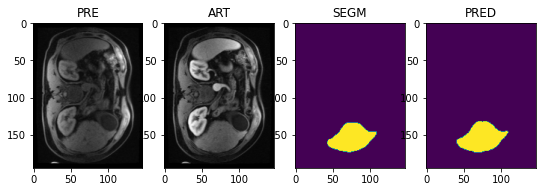

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/11524268_T1_PRE_REG_segm.nii.gz
torch.Size([2, 190, 155, 132])
torch.Size([1, 190, 155, 132])
torch.Size([1, 2, 190, 155, 132])
0.9560838937759399
63.35613624582863
11.593923355088085
torch.Size([2, 190, 155, 132])
torch.Size([1, 190, 155, 132])
torch.Size([1, 2, 190, 155, 132])
0.9694399237632751
1.4142135623730951
0.4674294819198655
torch.Size([1, 2, 190, 155, 132])
torch.Size([1, 190, 155, 132])


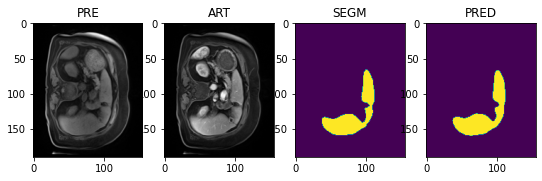

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E106458466_T1_PRE_REG_segm.nii.gz
torch.Size([2, 197, 160, 96])
torch.Size([1, 197, 160, 96])
torch.Size([1, 2, 197, 160, 96])
0.7321915030479431
99.12593000215135
40.0725303254095
torch.Size([2, 197, 160, 96])
torch.Size([1, 197, 160, 96])
torch.Size([1, 2, 197, 160, 96])
0.7440471053123474
100.12841751852143
39.48009301370591
torch.Size([1, 2, 197, 160, 96])
torch.Size([1, 197, 160, 96])


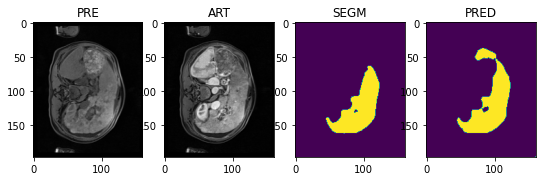

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E107235152_T1_PRE_REG_segm.nii.gz
torch.Size([2, 201, 201, 123])
torch.Size([1, 201, 201, 123])
torch.Size([1, 2, 201, 201, 123])
0.9488212466239929
2.8284271247461903
3.1074201917062685
torch.Size([2, 201, 201, 123])
torch.Size([1, 201, 201, 123])
torch.Size([1, 2, 201, 201, 123])
0.951401948928833
2.23606797749979
0.7950965621465702
torch.Size([1, 2, 201, 201, 123])
torch.Size([1, 201, 201, 123])


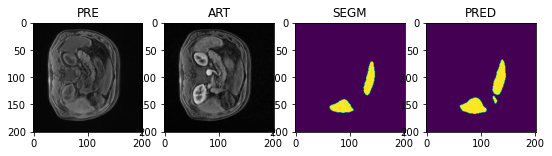

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E105198762_T1_PRE_REG_segm.nii.gz
torch.Size([2, 190, 164, 144])
torch.Size([1, 190, 164, 144])
torch.Size([1, 2, 190, 164, 144])
0.9578794836997986
50.80354318352215
4.885722155904644
torch.Size([2, 190, 164, 144])
torch.Size([1, 190, 164, 144])
torch.Size([1, 2, 190, 164, 144])
0.9629983901977539
2.8284271247461903
0.7280242785896921
torch.Size([1, 2, 190, 164, 144])
torch.Size([1, 190, 164, 144])


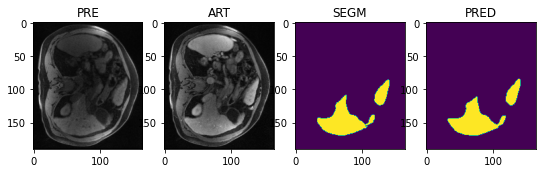

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/11148247_T1_PRE_REG_segm.nii.gz
torch.Size([2, 196, 192, 120])
torch.Size([1, 196, 192, 120])
torch.Size([1, 2, 196, 192, 120])
0.942528247833252
127.50294114254777
28.85349181670641
torch.Size([2, 196, 192, 120])
torch.Size([1, 196, 192, 120])
torch.Size([1, 2, 196, 192, 120])
0.970825731754303
2.0
0.5675777963041582
torch.Size([1, 2, 196, 192, 120])
torch.Size([1, 196, 192, 120])


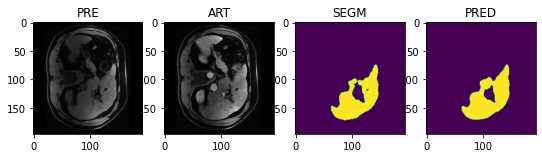

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E106751045_T1_PRE_REG_segm.nii.gz
torch.Size([2, 186, 186, 92])
torch.Size([1, 186, 186, 92])
torch.Size([1, 2, 186, 186, 92])
0.8560287356376648
103.16588417669381
35.01853095476747
torch.Size([2, 186, 186, 92])
torch.Size([1, 186, 186, 92])
torch.Size([1, 2, 186, 186, 92])
0.9244222044944763
6.4031242374328485
1.4642421347649186
torch.Size([1, 2, 186, 186, 92])
torch.Size([1, 186, 186, 92])


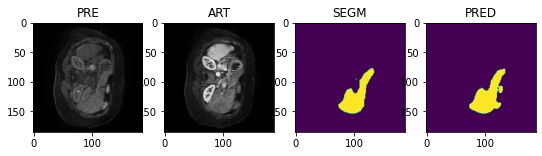

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/9648994_T1_PRE_REG_segm.nii.gz
torch.Size([2, 190, 148, 142])
torch.Size([1, 190, 148, 142])
torch.Size([1, 2, 190, 148, 142])
0.8757243752479553
103.58305843251196
30.055482776320353
torch.Size([2, 190, 148, 142])
torch.Size([1, 190, 148, 142])
torch.Size([1, 2, 190, 148, 142])
0.9667068123817444
2.0
0.6053088593796472
torch.Size([1, 2, 190, 148, 142])
torch.Size([1, 190, 148, 142])


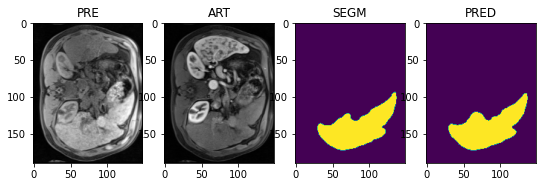

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E102928841_T1_PRE_REG_segm.nii.gz
torch.Size([2, 201, 151, 120])
torch.Size([1, 201, 151, 120])
torch.Size([1, 2, 201, 151, 120])
0.9262637495994568
100.67770358922576
21.097423425052682
torch.Size([2, 201, 151, 120])
torch.Size([1, 201, 151, 120])
torch.Size([1, 2, 201, 151, 120])
0.9726733565330505
1.4142135623730951
0.4641166322342973
torch.Size([1, 2, 201, 151, 120])
torch.Size([1, 201, 151, 120])


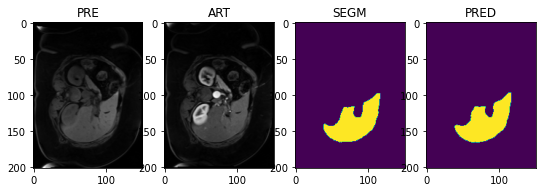

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E105426183_T1_PRE_REG_segm.nii.gz
torch.Size([2, 200, 163, 116])
torch.Size([1, 200, 163, 116])
torch.Size([1, 2, 200, 163, 116])
0.9358997941017151
87.61763513172343
18.93012108344677
torch.Size([2, 200, 163, 116])
torch.Size([1, 200, 163, 116])
torch.Size([1, 2, 200, 163, 116])
0.9686046838760376
1.4142135623730951
0.5873060122202085
torch.Size([1, 2, 200, 163, 116])
torch.Size([1, 200, 163, 116])


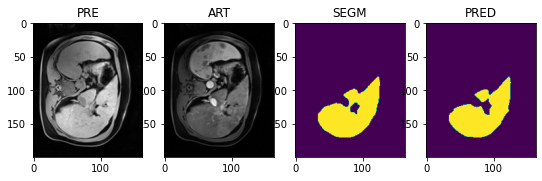

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E100142484_T1_PRE_REG_segm.nii.gz
torch.Size([2, 190, 155, 132])
torch.Size([1, 190, 155, 132])
torch.Size([1, 2, 190, 155, 132])
0.9685172438621521
9.917127738670679
2.662738998841657
torch.Size([2, 190, 155, 132])
torch.Size([1, 190, 155, 132])
torch.Size([1, 2, 190, 155, 132])
0.973033607006073
1.4142135623730951
0.5806953058706434
torch.Size([1, 2, 190, 155, 132])
torch.Size([1, 190, 155, 132])


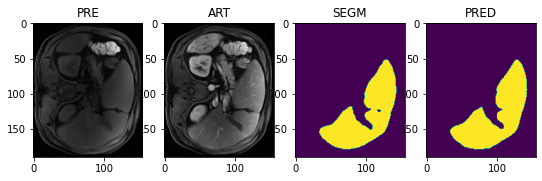

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E105829099_T1_PRE_REG_segm.nii.gz
torch.Size([2, 201, 201, 92])
torch.Size([1, 201, 201, 92])
torch.Size([1, 2, 201, 201, 92])
0.702751874923706
85.04704580407247
36.632851026980155
torch.Size([2, 201, 201, 92])
torch.Size([1, 201, 201, 92])
torch.Size([1, 2, 201, 201, 92])
0.7417522072792053
60.40695324215582
18.7922292597587
torch.Size([1, 2, 201, 201, 92])
torch.Size([1, 201, 201, 92])


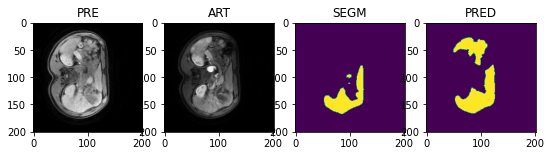

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/9586289_T1_PRE_REG_segm.nii.gz
torch.Size([2, 170, 133, 108])
torch.Size([1, 170, 133, 108])
torch.Size([1, 2, 170, 133, 108])
0.8001474142074585
53.91613854788128
12.952750003361144
torch.Size([2, 170, 133, 108])
torch.Size([1, 170, 133, 108])
torch.Size([1, 2, 170, 133, 108])
0.8178815245628357
37.36308338453881
7.954160003060432
torch.Size([1, 2, 170, 133, 108])
torch.Size([1, 170, 133, 108])


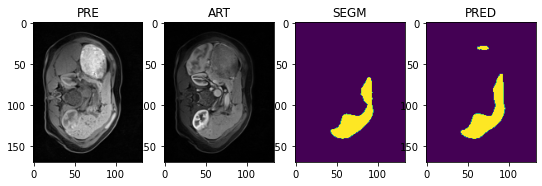

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E107156072_T1_PRE_REG_segm.nii.gz
torch.Size([2, 220, 174, 108])
torch.Size([1, 220, 174, 108])
torch.Size([1, 2, 220, 174, 108])
0.9190172553062439
85.44588931013593
25.20186755387717
torch.Size([2, 220, 174, 108])
torch.Size([1, 220, 174, 108])
torch.Size([1, 2, 220, 174, 108])
0.9741623997688293
1.4142135623730951
0.47916907150673865
torch.Size([1, 2, 220, 174, 108])
torch.Size([1, 220, 174, 108])


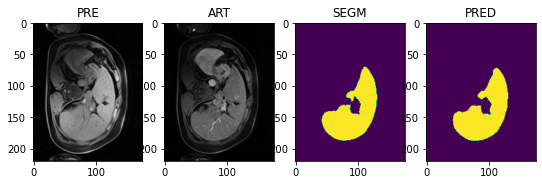

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E104998309_T1_PRE_REG_segm.nii.gz
torch.Size([2, 200, 173, 120])
torch.Size([1, 200, 173, 120])
torch.Size([1, 2, 200, 173, 120])
0.9624336361885071
75.53740789618058
13.253195950694801
torch.Size([2, 200, 173, 120])
torch.Size([1, 200, 173, 120])
torch.Size([1, 2, 200, 173, 120])
0.9779213070869446
1.4142135623730951
0.4359093100856329
torch.Size([1, 2, 200, 173, 120])
torch.Size([1, 200, 173, 120])


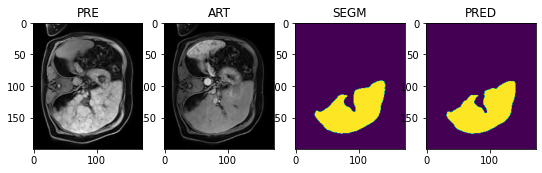

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E105615985_T1_PRE_REG_segm.nii.gz
torch.Size([2, 190, 149, 132])
torch.Size([1, 190, 149, 132])
torch.Size([1, 2, 190, 149, 132])
0.9646576046943665
12.083045973594572
2.841538546789476
torch.Size([2, 190, 149, 132])
torch.Size([1, 190, 149, 132])
torch.Size([1, 2, 190, 149, 132])
0.9655603170394897
6.268505859257977
1.282699588392071
torch.Size([1, 2, 190, 149, 132])
torch.Size([1, 190, 149, 132])


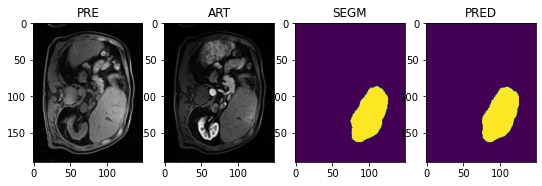

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/12916368_T1_PRE_REG_segm.nii.gz
torch.Size([2, 211, 181, 116])
torch.Size([1, 211, 181, 116])
torch.Size([1, 2, 211, 181, 116])
0.9215556383132935
103.27148686835103
28.746041323223366
torch.Size([2, 211, 181, 116])
torch.Size([1, 211, 181, 116])
torch.Size([1, 2, 211, 181, 116])
0.969940185546875
2.0
0.6954414819163011
torch.Size([1, 2, 211, 181, 116])
torch.Size([1, 211, 181, 116])


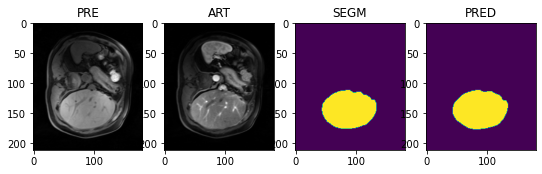

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E103814356_T1_PRE_REG_segm.nii.gz
torch.Size([2, 170, 144, 150])
torch.Size([1, 170, 144, 150])
torch.Size([1, 2, 170, 144, 150])
0.8937724232673645
57.15024050904639
14.371956903582582
torch.Size([2, 170, 144, 150])
torch.Size([1, 170, 144, 150])
torch.Size([1, 2, 170, 144, 150])
0.9511814117431641
2.449489742783178
0.9266145777737159
torch.Size([1, 2, 170, 144, 150])
torch.Size([1, 170, 144, 150])


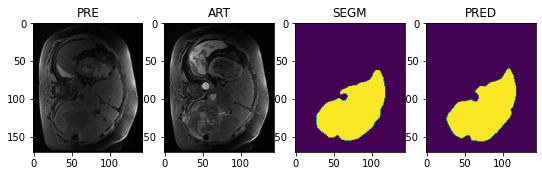

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/11022925_T1_PRE_REG_segm.nii.gz
torch.Size([2, 206, 206, 110])
torch.Size([1, 206, 206, 110])
torch.Size([1, 2, 206, 206, 110])
0.7843520045280457
124.47489706764172
51.85635496742562
torch.Size([2, 206, 206, 110])
torch.Size([1, 206, 206, 110])
torch.Size([1, 2, 206, 206, 110])
0.9636123776435852
2.0
0.5714061507154046
torch.Size([1, 2, 206, 206, 110])
torch.Size([1, 206, 206, 110])


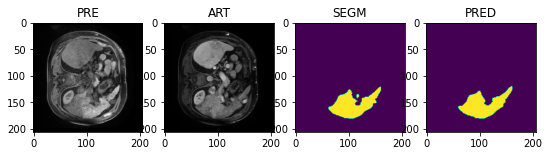

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E106533478_T1_PRE_REG_segm.nii.gz
torch.Size([2, 191, 143, 132])
torch.Size([1, 191, 143, 132])
torch.Size([1, 2, 191, 143, 132])
0.947390079498291
111.03062620824713
24.0218193286278
torch.Size([2, 191, 143, 132])
torch.Size([1, 191, 143, 132])
torch.Size([1, 2, 191, 143, 132])
0.9651280045509338
1.4142135623730951
0.5395446593103532
torch.Size([1, 2, 191, 143, 132])
torch.Size([1, 191, 143, 132])


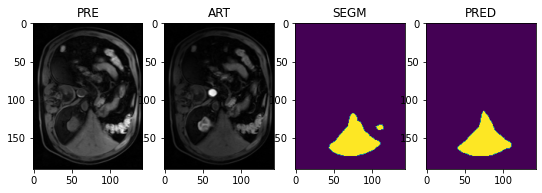

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E106851724_T1_PRE_REG_segm.nii.gz
torch.Size([2, 181, 181, 135])
torch.Size([1, 181, 181, 135])
torch.Size([1, 2, 181, 181, 135])
0.9126791954040527
60.315835400000886
10.519349312018603
torch.Size([2, 181, 181, 135])
torch.Size([1, 181, 181, 135])
torch.Size([1, 2, 181, 181, 135])
0.9564623832702637
2.23606797749979
0.7609382669301675
torch.Size([1, 2, 181, 181, 135])
torch.Size([1, 181, 181, 135])


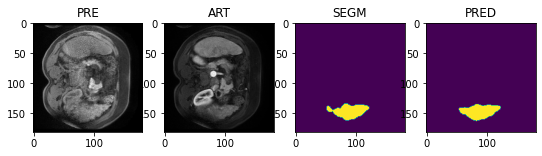

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E103511968_T1_PRE_REG_segm.nii.gz
torch.Size([2, 215, 173, 120])
torch.Size([1, 215, 173, 120])
torch.Size([1, 2, 215, 173, 120])
0.9395888447761536
56.04462507680822
8.950642650565653
torch.Size([2, 215, 173, 120])
torch.Size([1, 215, 173, 120])
torch.Size([1, 2, 215, 173, 120])
0.9703637361526489
1.4142135623730951
0.5029882598769222
torch.Size([1, 2, 215, 173, 120])
torch.Size([1, 215, 173, 120])


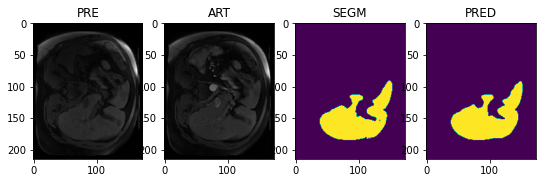

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E107553107_T1_PRE_REG_segm.nii.gz
torch.Size([2, 201, 151, 111])
torch.Size([1, 201, 151, 111])
torch.Size([1, 2, 201, 151, 111])
0.897546112537384
88.11413018998863
31.918841381400902
torch.Size([2, 201, 151, 111])
torch.Size([1, 201, 151, 111])
torch.Size([1, 2, 201, 151, 111])
0.9516971707344055
3.7416573867739413
1.2194197447261566
torch.Size([1, 2, 201, 151, 111])
torch.Size([1, 201, 151, 111])


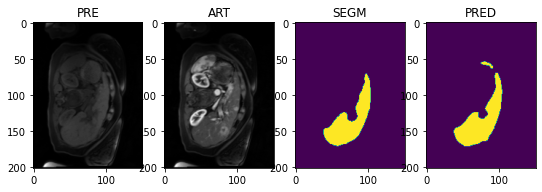

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E100588448_T1_PRE_REG_segm.nii.gz
torch.Size([2, 236, 232, 120])
torch.Size([1, 236, 232, 120])
torch.Size([1, 2, 236, 232, 120])
0.9507034420967102
55.034532992421155
11.477835687041662
torch.Size([2, 236, 232, 120])
torch.Size([1, 236, 232, 120])
torch.Size([1, 2, 236, 232, 120])
0.9707651734352112
2.0
0.5871381964991642
torch.Size([1, 2, 236, 232, 120])
torch.Size([1, 236, 232, 120])


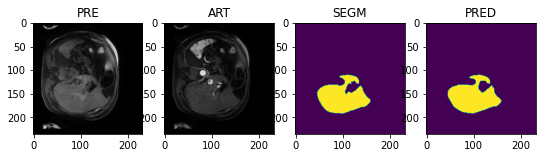

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E104134228_T1_PRE_REG_segm.nii.gz
torch.Size([2, 211, 211, 110])
torch.Size([1, 211, 211, 110])
torch.Size([1, 2, 211, 211, 110])
0.7226014137268066
137.02919377544185
66.5949747120892
torch.Size([2, 211, 211, 110])
torch.Size([1, 211, 211, 110])
torch.Size([1, 2, 211, 211, 110])
0.9595018625259399
1.7320508075688772
0.6287548268953089
torch.Size([1, 2, 211, 211, 110])
torch.Size([1, 211, 211, 110])


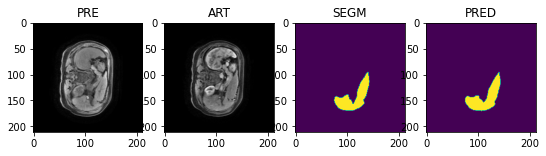

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E101686218_T1_PRE_REG_segm.nii.gz
torch.Size([2, 210, 181, 108])
torch.Size([1, 210, 181, 108])
torch.Size([1, 2, 210, 181, 108])
0.9366891384124756
120.07247789272557
22.547597462051424
torch.Size([2, 210, 181, 108])
torch.Size([1, 210, 181, 108])
torch.Size([1, 2, 210, 181, 108])
0.9669066667556763
2.0
0.637324372539335
torch.Size([1, 2, 210, 181, 108])
torch.Size([1, 210, 181, 108])


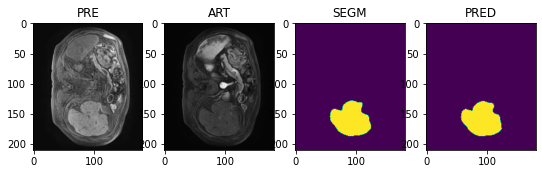

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E100967188_T1_PRE_REG_segm.nii.gz
torch.Size([2, 225, 181, 131])
torch.Size([1, 225, 181, 131])
torch.Size([1, 2, 225, 181, 131])
0.9624789953231812
69.57729514719583
5.827613728527795
torch.Size([2, 225, 181, 131])
torch.Size([1, 225, 181, 131])
torch.Size([1, 2, 225, 181, 131])
0.9710834622383118
1.4142135623730951
0.6161774802184864
torch.Size([1, 2, 225, 181, 131])
torch.Size([1, 225, 181, 131])


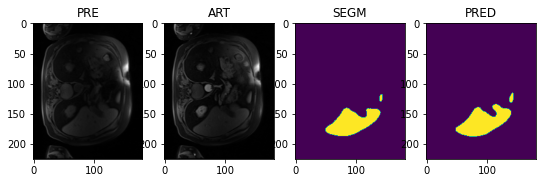

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E107476766_T1_PRE_REG_segm.nii.gz
torch.Size([2, 200, 161, 115])
torch.Size([1, 200, 161, 115])
torch.Size([1, 2, 200, 161, 115])
0.8523198962211609
74.83314773547883
26.513335390251044
torch.Size([2, 200, 161, 115])
torch.Size([1, 200, 161, 115])
torch.Size([1, 2, 200, 161, 115])
0.9536696672439575
1.7320508075688772
0.5963995063625188
torch.Size([1, 2, 200, 161, 115])
torch.Size([1, 200, 161, 115])


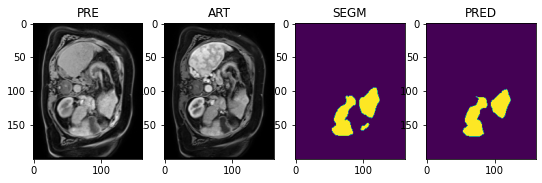

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E104250009_T1_PRE_REG_segm.nii.gz
torch.Size([2, 200, 156, 132])
torch.Size([1, 200, 156, 132])
torch.Size([1, 2, 200, 156, 132])
0.9690442085266113
68.47627326307996
9.77072737792901
torch.Size([2, 200, 156, 132])
torch.Size([1, 200, 156, 132])
torch.Size([1, 2, 200, 156, 132])
0.9766806960105896
1.4142135623730951
0.443810288589945
torch.Size([1, 2, 200, 156, 132])
torch.Size([1, 200, 156, 132])


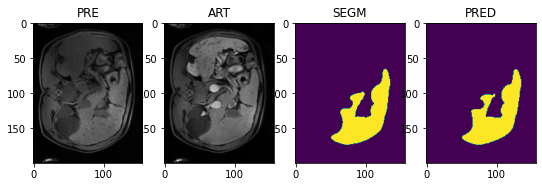

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E105152299_T1_PRE_REG_segm.nii.gz
torch.Size([2, 192, 192, 108])
torch.Size([1, 192, 192, 108])
torch.Size([1, 2, 192, 192, 108])
0.6881415247917175
116.83150258215561
41.77044392673465
torch.Size([2, 192, 192, 108])
torch.Size([1, 192, 192, 108])
torch.Size([1, 2, 192, 192, 108])
0.9666463732719421
1.4142135623730951
0.48853186795494724
torch.Size([1, 2, 192, 192, 108])
torch.Size([1, 192, 192, 108])


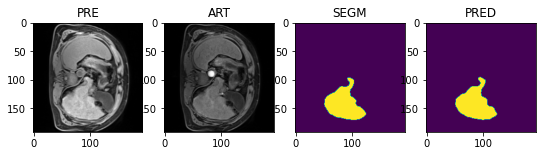

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/11308203_T1_PRE_REG_segm.nii.gz
torch.Size([2, 201, 151, 120])
torch.Size([1, 201, 151, 120])
torch.Size([1, 2, 201, 151, 120])
0.951050877571106
75.48509786706248
14.292277277557659
torch.Size([2, 201, 151, 120])
torch.Size([1, 201, 151, 120])
torch.Size([1, 2, 201, 151, 120])
0.9706637263298035
1.4142135623730951
0.5720583062558862
torch.Size([1, 2, 201, 151, 120])
torch.Size([1, 201, 151, 120])


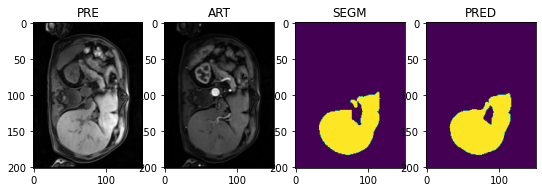

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E107046127_T1_PRE_REG_segm.nii.gz
torch.Size([2, 230, 180, 120])
torch.Size([1, 230, 180, 120])
torch.Size([1, 2, 230, 180, 120])
0.9243277907371521
95.81544535550827
23.180454966232688
torch.Size([2, 230, 180, 120])
torch.Size([1, 230, 180, 120])
torch.Size([1, 2, 230, 180, 120])
0.9597330689430237
2.0
0.5856576726747663
torch.Size([1, 2, 230, 180, 120])
torch.Size([1, 230, 180, 120])


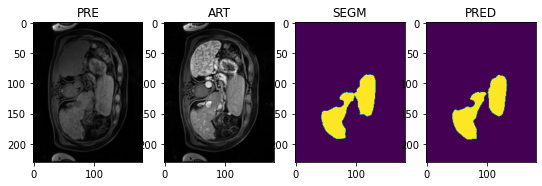

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/13106408_T1_PRE_REG_segm.nii.gz
torch.Size([2, 210, 158, 120])
torch.Size([1, 210, 158, 120])
torch.Size([1, 2, 210, 158, 120])
0.8744105100631714
109.88175462741756
31.318368402154768
torch.Size([2, 210, 158, 120])
torch.Size([1, 210, 158, 120])
torch.Size([1, 2, 210, 158, 120])
0.9615541100502014
1.4142135623730951
0.5439867406203327
torch.Size([1, 2, 210, 158, 120])
torch.Size([1, 210, 158, 120])


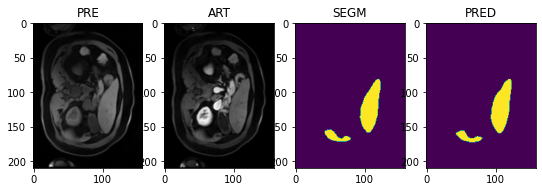

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E102486953_T1_PRE_REG_segm.nii.gz
torch.Size([2, 170, 149, 120])
torch.Size([1, 170, 149, 120])
torch.Size([1, 2, 170, 149, 120])
0.6336606740951538
66.46051459325304
26.54845804965443
torch.Size([2, 170, 149, 120])
torch.Size([1, 170, 149, 120])
torch.Size([1, 2, 170, 149, 120])
0.6671257019042969
57.45519987942705
20.644606866004874
torch.Size([1, 2, 170, 149, 120])
torch.Size([1, 170, 149, 120])


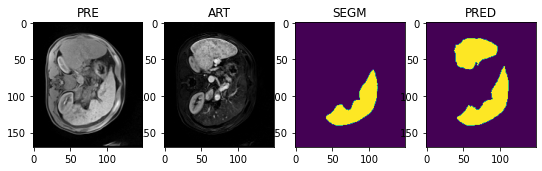

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E101055640_T1_PRE_REG_segm.nii.gz
torch.Size([2, 200, 137, 120])
torch.Size([1, 200, 137, 120])
torch.Size([1, 2, 200, 137, 120])
0.9500299692153931
57.358521598799946
7.310875977010466
torch.Size([2, 200, 137, 120])
torch.Size([1, 200, 137, 120])
torch.Size([1, 2, 200, 137, 120])
0.9563890099525452
10.712123534080533
0.5801334116503247
torch.Size([1, 2, 200, 137, 120])
torch.Size([1, 200, 137, 120])


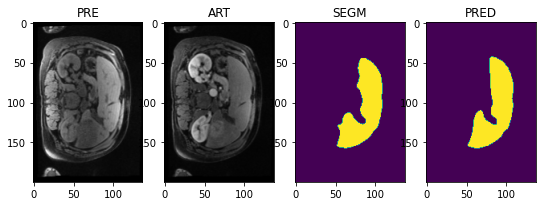

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/10807315_T1_PRE_REG_segm.nii.gz
torch.Size([2, 210, 164, 120])
torch.Size([1, 210, 164, 120])
torch.Size([1, 2, 210, 164, 120])
0.8837774395942688
84.06899168181806
23.958233695991193
torch.Size([2, 210, 164, 120])
torch.Size([1, 210, 164, 120])
torch.Size([1, 2, 210, 164, 120])
0.973827600479126
1.4142135623730951
0.43073795225097405
torch.Size([1, 2, 210, 164, 120])
torch.Size([1, 210, 164, 120])


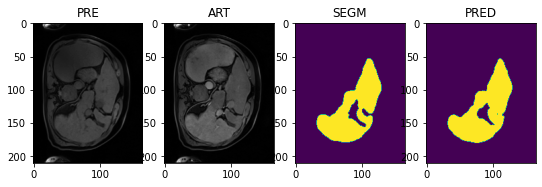

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/13170972_T1_PRE_REG_segm.nii.gz
torch.Size([2, 205, 154, 155])
torch.Size([1, 205, 154, 155])
torch.Size([1, 2, 205, 154, 155])
0.8286495208740234
84.5428883689528
22.033853977356337
torch.Size([2, 205, 154, 155])
torch.Size([1, 205, 154, 155])
torch.Size([1, 2, 205, 154, 155])
0.8453813195228577
71.449282711585
13.709450199833197
torch.Size([1, 2, 205, 154, 155])
torch.Size([1, 205, 154, 155])


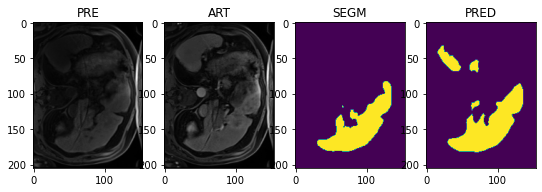

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E104594843_T1_PRE_REG_segm.nii.gz
torch.Size([2, 231, 231, 144])
torch.Size([1, 231, 231, 144])
torch.Size([1, 2, 231, 231, 144])
0.9753984808921814
1.4142135623730951
0.5048411917284047
torch.Size([2, 231, 231, 144])
torch.Size([1, 231, 231, 144])
torch.Size([1, 2, 231, 231, 144])
0.9753984808921814
1.4142135623730951
0.5048411917284047
torch.Size([1, 2, 231, 231, 144])
torch.Size([1, 231, 231, 144])


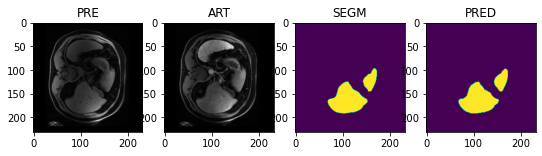

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E104034609_T1_PRE_REG_segm.nii.gz
torch.Size([2, 191, 141, 120])
torch.Size([1, 191, 141, 120])
torch.Size([1, 2, 191, 141, 120])
0.8094578981399536
77.41963570907642
22.027457950423518
torch.Size([2, 191, 141, 120])
torch.Size([1, 191, 141, 120])
torch.Size([1, 2, 191, 141, 120])
0.9605104923248291
2.0
0.732558075296692
torch.Size([1, 2, 191, 141, 120])
torch.Size([1, 191, 141, 120])


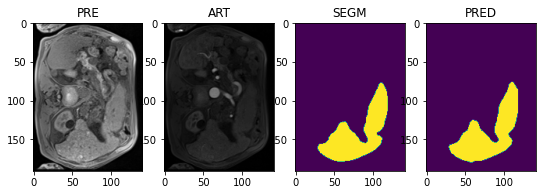

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E107774979_T1_PRE_REG_segm.nii.gz
torch.Size([2, 210, 164, 120])
torch.Size([1, 210, 164, 120])
torch.Size([1, 2, 210, 164, 120])
0.9544952511787415
61.36774397026503
7.179615792255892
torch.Size([2, 210, 164, 120])
torch.Size([1, 210, 164, 120])
torch.Size([1, 2, 210, 164, 120])
0.966831624507904
1.4142135623730951
0.5045860013218342
torch.Size([1, 2, 210, 164, 120])
torch.Size([1, 210, 164, 120])


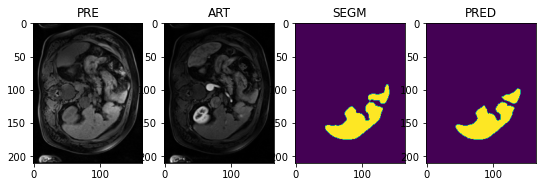

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E104900599_T1_PRE_REG_segm.nii.gz
torch.Size([2, 230, 180, 142])
torch.Size([1, 230, 180, 142])
torch.Size([1, 2, 230, 180, 142])
0.9641010165214539
9.066394826338634
4.104862691144986
torch.Size([2, 230, 180, 142])
torch.Size([1, 230, 180, 142])
torch.Size([1, 2, 230, 180, 142])
0.9678176045417786
1.4142135623730951
0.5956488428968935
torch.Size([1, 2, 230, 180, 142])
torch.Size([1, 230, 180, 142])


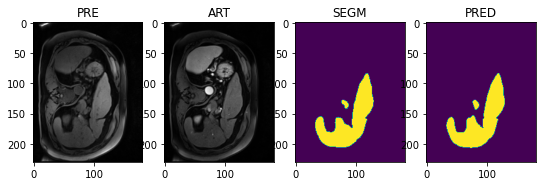

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E104657225_T1_PRE_REG_segm.nii.gz
torch.Size([2, 180, 135, 108])
torch.Size([1, 180, 135, 108])
torch.Size([1, 2, 180, 135, 108])
0.8237662315368652
75.71525595478548
19.29961162859719
torch.Size([2, 180, 135, 108])
torch.Size([1, 180, 135, 108])
torch.Size([1, 2, 180, 135, 108])
0.8282709717750549
64.84674235958089
14.028831660491068
torch.Size([1, 2, 180, 135, 108])
torch.Size([1, 180, 135, 108])


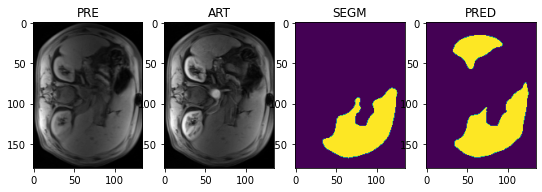

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E105599954_T1_PRE_REG_segm.nii.gz
torch.Size([2, 235, 183, 132])
torch.Size([1, 235, 183, 132])
torch.Size([1, 2, 235, 183, 132])
0.8665257692337036
34.72751070837067
7.4031765773687175
torch.Size([2, 235, 183, 132])
torch.Size([1, 235, 183, 132])
torch.Size([1, 2, 235, 183, 132])
0.8703275322914124
23.259406699226016
3.8434159704504354
torch.Size([1, 2, 235, 183, 132])
torch.Size([1, 235, 183, 132])


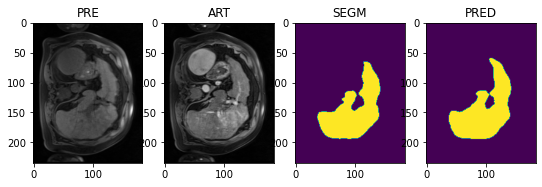

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E103570649_T1_PRE_REG_segm.nii.gz
torch.Size([2, 200, 156, 127])
torch.Size([1, 200, 156, 127])
torch.Size([1, 2, 200, 156, 127])
0.9478035569190979
59.39696961966999
7.367007245499124
torch.Size([2, 200, 156, 127])
torch.Size([1, 200, 156, 127])
torch.Size([1, 2, 200, 156, 127])
0.9596791863441467
2.0
0.6058575558959068
torch.Size([1, 2, 200, 156, 127])
torch.Size([1, 200, 156, 127])


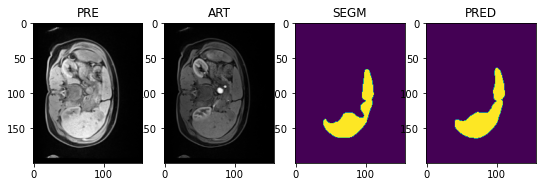

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E105504009_T1_PRE_REG_segm.nii.gz
torch.Size([2, 211, 152, 104])
torch.Size([1, 211, 152, 104])
torch.Size([1, 2, 211, 152, 104])
0.7487953901290894
79.98749902328488
31.30142232610016
torch.Size([2, 211, 152, 104])
torch.Size([1, 211, 152, 104])
torch.Size([1, 2, 211, 152, 104])
0.9611436724662781
2.0
0.7140243406117331
torch.Size([1, 2, 211, 152, 104])
torch.Size([1, 211, 152, 104])


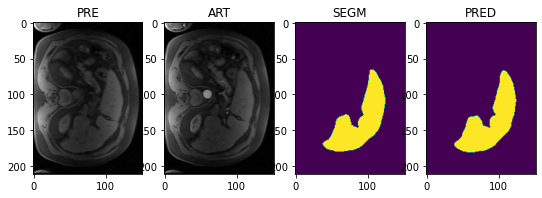

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E103831361_T1_PRE_REG_segm.nii.gz
torch.Size([2, 221, 221, 119])
torch.Size([1, 221, 221, 119])
torch.Size([1, 2, 221, 221, 119])
0.8029515147209167
93.6269192059634
35.94835056939779
torch.Size([2, 221, 221, 119])
torch.Size([1, 221, 221, 119])
torch.Size([1, 2, 221, 221, 119])
0.9559788703918457
2.449489742783178
0.7701969430175188
torch.Size([1, 2, 221, 221, 119])
torch.Size([1, 221, 221, 119])


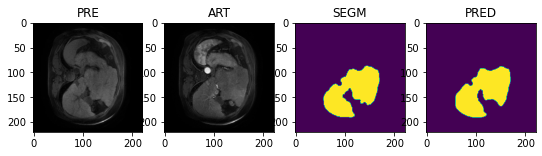

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/10843891_T1_PRE_REG_segm.nii.gz
torch.Size([2, 175, 137, 120])
torch.Size([1, 175, 137, 120])
torch.Size([1, 2, 175, 137, 120])
0.9421786665916443
102.74726273726225
16.196443089302026
torch.Size([2, 175, 137, 120])
torch.Size([1, 175, 137, 120])
torch.Size([1, 2, 175, 137, 120])
0.967321515083313
2.0
0.573091203210525
torch.Size([1, 2, 175, 137, 120])
torch.Size([1, 175, 137, 120])


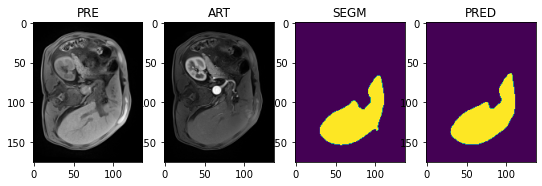

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E101762106_T1_PRE_REG_segm.nii.gz
torch.Size([2, 190, 149, 120])
torch.Size([1, 190, 149, 120])
torch.Size([1, 2, 190, 149, 120])
0.947041392326355
91.44287799177299
13.35322153161128
torch.Size([2, 190, 149, 120])
torch.Size([1, 190, 149, 120])
torch.Size([1, 2, 190, 149, 120])
0.962234377861023
1.7320508075688772
0.5890219303279495
torch.Size([1, 2, 190, 149, 120])
torch.Size([1, 190, 149, 120])


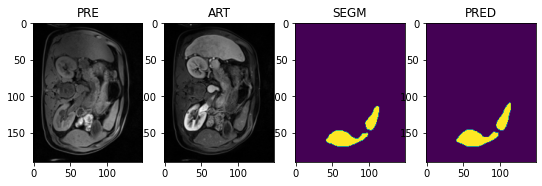

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/12543786_T1_PRE_REG_segm.nii.gz
torch.Size([2, 200, 163, 120])
torch.Size([1, 200, 163, 120])
torch.Size([1, 2, 200, 163, 120])
0.9439899921417236
84.86224125998795
15.719805602755258
torch.Size([2, 200, 163, 120])
torch.Size([1, 200, 163, 120])
torch.Size([1, 2, 200, 163, 120])
0.9592482447624207
1.7320508075688772
0.5797501220033618
torch.Size([1, 2, 200, 163, 120])
torch.Size([1, 200, 163, 120])


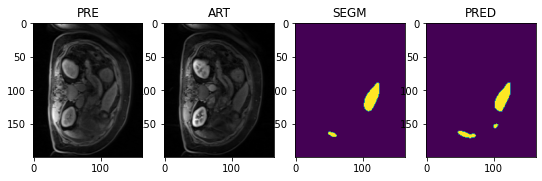

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E107077373_T1_PRE_REG_segm.nii.gz
torch.Size([2, 220, 172, 120])
torch.Size([1, 220, 172, 120])
torch.Size([1, 2, 220, 172, 120])
0.921030580997467
73.8850458482635
19.10881996738035
torch.Size([2, 220, 172, 120])
torch.Size([1, 220, 172, 120])
torch.Size([1, 2, 220, 172, 120])
0.9699799418449402
1.4142135623730951
0.5069402034708116
torch.Size([1, 2, 220, 172, 120])
torch.Size([1, 220, 172, 120])


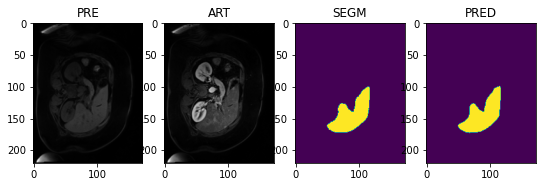

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PRE-ART/E106501028_T1_PRE_REG_segm.nii.gz
[0.9271154403686523, 0.900335967540741, 0.9385819435119629, 0.7491883635520935, 0.8352509140968323, 0.8687925338745117, 0.8580420613288879, 0.949665904045105, 0.909900963306427, 0.8755887150764465, 0.9245312213897705, 0.9334313869476318, 0.8009957671165466, 0.8650360107421875, 0.9500527381896973, 0.9472425580024719, 0.9107709527015686, 0.9559006094932556, 0.9003240466117859, 0.8727530241012573, 0.8671876192092896, 0.8902854919433594, 0.5413159728050232, 0.8305402994155884, 0.9256715774536133, 0.9222959876060486, 0.9072135090827942, 0.9276397824287415, 0.9668298363685608, 0.9562997221946716, 0.9039607048034668, 0.8002381324768066, 0.9276695847511292, 0.9292809367179871, 0.9686000347137451, 0.9415494203567505, 0.967158317565918, 0.9742562174797058, 0.9638040065765381, 0.9560838937759399, 0.7321915030479431, 0.9488212466239929, 0.9578794836997986, 0.94252824783

DICE  POST_DICE       HD95  POST_HD95  InferenceTime  \
0  0.927115   0.964495  72.456884   1.414214       0.011111   
1  0.900336   0.974391  78.727378   1.414214       0.005161   
2  0.938582   0.967836  75.315997   1.414214       0.004398   
3  0.749188   0.935698  79.737068   3.605551       0.015026   
4  0.835251   0.894310  84.976762  50.734604       0.008710   

                                AUTOMATED-LIVER-SEGM   EXPERIMENT_ID  
0  /tensor5/data1/mgross/Liver/studies/Contrast-N...  2mpMRI-PRE-ART  
1  /tensor5/data1/mgross/Liver/studies/Contrast-N...  2mpMRI-PRE-ART  
2  /tensor5/data1/mgross/Liver/studies/Contrast-N...  2mpMRI-PRE-ART  
3  /tensor5/data1/mgross/Liver/studies/Contrast-N...  2mpMRI-PRE-ART  
4  /tensor5/data1/mgross/Liver/studies/Contrast-N...  2mpMRI-PRE-ART

In [42]:
roi_size = (224, 224, 128)

df_test_results = run_inference_and_evaluate(
        model=model, 
        data_loader= test_loader, 
        roi_size=roi_size, 
        plot_images=True, 
        save_output=True,
    output_path= OUTPUT_PATH)
    #max_eval = 2)


torch.cuda.empty_cache()
df_test_results['EXPERIMENT_ID'] = '2mpMRI-PRE-ART'
df_test_results.head()

In [45]:
df_test_results.to_csv('../Results/Results-2mpMRI-Net_PRE-ART.csv')

## External Testing

In [56]:
from monai.data import Dataset, DataLoader, pad_list_data_collate
from monai.data import decollate_batch

def compute_evaluation_metrics(y_pred, y, keep=False):
    
    argmax = monai.transforms.AsDiscrete(argmax=True)
    one_hot = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
    dice = monai.metrics.DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
    hd = monai.metrics.HausdorffDistanceMetric(include_background=False, reduction="mean", percentile=95, get_not_nans=False)
    mad = monai.metrics.SurfaceDistanceMetric(include_background=False, reduction="mean", get_not_nans=False)
    keep_largest = monai.transforms.KeepLargestConnectedComponent(applied_labels=[1])

    dice_list = list()
    hd_list = list()
    mad_list = list()
    for y_pred_i, y_i in decollate_batch((y_pred, y)):
        print(y_pred_i.shape)
        print(y_i.shape)
        if keep:
            #dice(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            #hd(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            #mad(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            y_pred_i_proc=one_hot(keep_largest(argmax(y_pred_i)))
        else:
                
            # Calculate Dice on the raw output
            #dice(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            #hd(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            #mad(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            y_pred_i_proc = one_hot(argmax(y_pred_i))
        y_pred_i_proc = monai.transforms.AddChannel()(y_pred_i_proc)
        y_i_proc = monai.transforms.AddChannel()(one_hot(y_i))
        print(y_pred_i_proc.shape)
            
        #dice(y_pred=y_pred_i_proc, y=one_hot(y_i))
        #hd(y_pred=y_pred_i_proc, y=one_hot(y_i))
        #mad(y_pred=y_pred_i_proc, y=one_hot(y_i))
            
        dice(y_pred=y_pred_i_proc, y=y_i_proc)
        hd(y_pred=y_pred_i_proc, y=y_i_proc)
        mad(y_pred=y_pred_i_proc, y=y_i_proc)
        
        dice_value = dice.aggregate().item()
        hd_value = hd.aggregate().item()
        mad_value = mad.aggregate().item()
        
        print(dice_value)
        print(hd_value)
        print(mad_value)
        
        dice_list.append(dice_value)
        hd_list.append(hd_value)
        mad_list.append(mad_value)
              
    return dice_list, hd_list, mad_list


def run_inference_and_evaluate(model, data_loader, plot_images=False, max_eval=None, 
                               save_output=False,roi_size=(224,224,128), sw_batch_size=4, output_path=None):
    
    """Inference and evaluation function for Liver segmentation.
    
    """   
    
    df_eval = pd.DataFrame()
    
    acc_ids = list()
    input_paths = list()
    output_paths = list()
    
    original_dice_results = list()
    postprocess_dice_results = list()

    original_hd_results = list()
    postprocess_hd_results = list()

    original_mad_results = list()
    postprocess_mad_results = list()
    
    inference_times = list()
    


    
    # Use MONAI one_hot transform
    argmax = monai.transforms.AsDiscrete(argmax=True)
    one_hot = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
    dice = monai.metrics.DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
    keep = monai.transforms.KeepLargestConnectedComponent(applied_labels=[1])

    with torch.no_grad():
        for i, test_data in tqdm(enumerate(data_loader)):
        # Early stopping
            if max_eval is not None:
                if i>=max_eval:
                    break

            #print(test_data['ACCESSION_ID'][0])
            #for val in test_data['ACCESSION_ID'][0]:
            #    acc_ids.append(val)

    
            pre_images =  test_data["PRE"].to(device)
            art_images =  test_data["ART"].to(device)
            
            
            x = torch.cat((pre_images, art_images) ,dim=1)
            y = test_data['SEGM'].cpu()




            stpre_time = time.time()
            y_pred = sliding_window_inference(x, roi_size, sw_batch_size, model)
            stop_time = time.time()

            inference_time = stop_time-stpre_time
            inference_times.append(inference_time)

            x = x.detach().cpu()
            y_pred = y_pred.detach().cpu()
            #print(y_pred.shape)

            #argmax = torch.argmax(y_pred, dim=1, keepdim=True)
            #argmax = argmax.detach().cpu()

            #y_onehot = one_hot(y)
            #y_pred_onehot = one_hot(argmax)

            # Evaluate segmentation metrics
            eval_list = list()
            # Update to MONAI 0.7+
            dice_values, hd_values, mad_values = compute_evaluation_metrics(
                y_pred=y_pred, y=y
            )

            for val in dice_values:
                original_dice_results.append(val)
            for val in hd_values:
                original_hd_results.append(val)
            for val in mad_values:
                original_mad_results.append(val)



            post_dice_values, post_hd_values, post_mad_values = compute_evaluation_metrics(
                y_pred=y_pred, y=y, keep=True
            )        #dice_list = list()
            #post_dice_list = list()

            for val in post_dice_values:
                postprocess_dice_results.append(val)
            for val in post_hd_values:
                postprocess_hd_results.append(val)
            for val in post_mad_values:
                postprocess_mad_results.append(val)





            print(y_pred.shape)
            print(argmax(y_pred[0,...]).shape)


            if plot_images:
                pre_img = pre_images.detach().cpu()
                art_img = art_images.detach().cpu()
                


                slice_num = x.shape[-1]//2

                plt.figure('check', (9, 3))
                plt.subplot(1, 4, 1)
                plt.title('PRE')
                plt.imshow(pre_img[0,0,:,:,slice_num], cmap='gray')

                plt.subplot(1, 4, 2)
                plt.title('ART')
                plt.imshow(art_img[0,0,:,:,slice_num], cmap='gray')

            
                plt.subplot(1, 4, 3)
                plt.title('SEGM')
                plt.imshow(y[0,0,:,:,slice_num])

                plt.subplot(1, 4, 4)
                plt.title('PRED')
                #plt.imshow(argmax(y_pred[0,...])[0,:,:,slice_num])
                plt.imshow(keep(argmax(y_pred[0,...]))[0,:,:,slice_num])
                plt.show()


            # Write data out
            if save_output:
                # Get the image affine matrix
                current_affine = test_data['pre_meta_dict']['affine'][0].numpy()
                original_affine = test_data['pre_meta_dict']['original_affine'][0].numpy()
                original_spatial_shape = test_data['pre_meta_dict']['spatial_shape'][0].numpy()

                input_file_name = test_data['pre_meta_dict']['filename_or_obj'][0]
                output_file_name = os.path.split(input_file_name)[1]
                output_root_name = output_file_name[:-len('.nii.gz')]
                
                
                output_root_name = str(test_data['ACCESSION_ID'][0])
                
                output_path_final = os.path.join(output_path,'{}_segm.nii.gz'.format(output_root_name))
                print('Saving segmentation results: {}'.format(output_path_final))
                
                output_paths.append(output_path_final)
                
                #output_segm = argmax.cpu()[0, 0,...].numpy()
                output_segm = keep(argmax(y_pred[0,...])).cpu()[0,...].numpy()
                write_nifti(output_segm, output_path_final,
                            mode='nearest',
                            affine=current_affine, 
                            target_affine=original_affine,
                            output_spatial_shape=original_spatial_shape, 
                            dtype=np.float32
                           )

    
    #df_eval['ACCESSION_ID'] = acc_ids
    #df_eval['ART'] = input_paths
    df_eval['DICE'] = original_dice_results
    print(original_dice_results)
    df_eval['POST_DICE'] = postprocess_dice_results
    df_eval['HD95'] = original_hd_results
    df_eval['POST_HD95'] = postprocess_hd_results
    #df_eval['MAD'] = original_mad_results
    #df_eval['POST_MAD'] = postprocess_mad_results
    df_eval['InferenceTime'] = inference_times
    if output_path is not None:
        df_eval['AUTOMATED-LIVER-SEGM'] = output_paths    
    return df_eval


In [57]:
import glob 
import pandas as pd

external_testing_img_paths = pd.read_csv('/tensor5/data1/jonofrey/Liver/Paris/registration/nonrigid_nmi/Nonrigid_Registered_NMI_Image_Paths.csv')

included_accs = [1,3, 4, 6, 10, 11, 12, 17, 18, 19, 22, 32, 35, 40, 55, 59]
external_testing_img_paths = external_testing_img_paths[external_testing_img_paths['ACCESSION_ID'].isin(included_accs)]

segm_path = '/tensor5/data1/mgross/Liver/Paris/man_liver_segms/*_PV_LIVER-label.nii.gz'
segm_paths = glob.glob(segm_path)

external_testing_accs = [int(i.split('/')[-1].split('_')[0]) for i in segm_paths]

df_external_testing = pd.DataFrame({'ACCESSION_ID': external_testing_accs, 'SEGM' : segm_paths})
df_external_testing = pd.merge(external_testing_img_paths, df_external_testing, on = 'ACCESSION_ID')



df_external_testing


ACCESSION_ID                                                PRE  \
0              1  /tensor5/data1/mgross/Liver/Paris/00001/00001_...   
1              3  /tensor5/data1/mgross/Liver/Paris/00003/00003_...   
2              4  /tensor5/data1/mgross/Liver/Paris/00004/00004_...   
3              6  /tensor5/data1/mgross/Liver/Paris/00006/00006_...   
4             10  /tensor5/data1/mgross/Liver/Paris/00010/00010_...   
5             11  /tensor5/data1/mgross/Liver/Paris/00011/00011_...   
6             12  /tensor5/data1/mgross/Liver/Paris/00012/00012_...   
7             17  /tensor5/data1/mgross/Liver/Paris/00017/00017_...   
8             18  /tensor5/data1/mgross/Liver/Paris/00018/00018_...   
9             19  /tensor5/data1/mgross/Liver/Paris/00019/00019_...   
10            22  /tensor5/data1/mgross/Liver/Paris/00022/00022_...   
11            32  /tensor5/data1/mgross/Liver/Paris/00032/00032_...   
12            35  /tensor5/data1/mgross/Liver/Paris/00035/00035_...   
13            40  /tensor5/data1/mgross/Liver/Paris/00040/00040_...   
14            55  /tensor5/data1/mgross/Liver/Paris/00055/00055_...   
15            59  /tensor5/data1/mgross/Liver/Paris/00059/00059_...   

                                                  ART  \
0   /tensor5/data1/mgross/Liver/Paris/00001/00001_...   
1   /tensor5/data1/mgross/Liver/Paris/00003/00003_...   
2   /tensor5/data1/mgross/Liver/Paris/00004/00004_...   
3   /tensor5/data1/mgross/Liver/Paris/00006/00006_...   
4   /tensor5/data1/mgross/Liver/Paris/00010/00010_...   
5   /tensor5/data1/mgross/Liver/Paris/00011/00011_...   
6   /tensor5/data1/mgross/Liver/Paris/00012/00012_...   
7   /tensor5/data1/mgross/Liver/Paris/00017/00017_...   
8   /tensor5/data1/mgross/Liver/Paris/00018/00018_...   
9   /tensor5/data1/mgross/Liver/Paris/00019/00019_...   
10  /tensor5/data1/mgross/Liver/Paris/00022/00022_...   
11  /tensor5/data1/mgross/Liver/Paris/00032/00032_...   
12  /tensor5/data1/mgross/Liver/Paris/00035/00035_...   
13  /tensor5/data1/mgross/Liver/Paris/00040/00040_...   
14  /tensor5/data1/mgross/Liver/Paris/00055/00055_...   
15  /tensor5/data1/mgross/Liver/Paris/00059/00059_...   

                                                   PV  \
0   /tensor5/data1/mgross/Liver/Paris/00001/00001_...   
1   /tensor5/data1/mgross/Liver/Paris/00003/00003_...   
2   /tensor5/data1/mgross/Liver/Paris/00004/00004_...   
3   /tensor5/data1/mgross/Liver/Paris/00006/00006_...   
4   /tensor5/data1/mgross/Liver/Paris/00010/00010_...   
5   /tensor5/data1/mgross/Liver/Paris/00011/00011_...   
6   /tensor5/data1/mgross/Liver/Paris/00012/00012_...   
7   /tensor5/data1/mgross/Liver/Paris/00017/00017_...   
8   /tensor5/data1/mgross/Liver/Paris/00018/00018_...   
9   /tensor5/data1/mgross/Liver/Paris/00019/00019_...   
10  /tensor5/data1/mgross/Liver/Paris/00022/00022_...   
11  /tensor5/data1/mgross/Liver/Paris/00032/00032_...   
12  /tensor5/data1/mgross/Liver/Paris/00035/00035_...   
13  /tensor5/data1/mgross/Liver/Paris/00040/00040_...   
14  /tensor5/data1/mgross/Liver/Paris/00055/00055_...   
15  /tensor5/data1/mgross/Liver/Paris/00059/00059_...   

                                                  DEL  \
0   /tensor5/data1/mgross/Liver/Paris/00001/00001_...   
1   /tensor5/data1/mgross/Liver/Paris/00003/00003_...   
2   /tensor5/data1/mgross/Liver/Paris/00004/00004_...   
3   /tensor5/data1/mgross/Liver/Paris/00006/00006_...   
4   /tensor5/data1/mgross/Liver/Paris/00010/00010_...   
5   /tensor5/data1/mgross/Liver/Paris/00011/00011_...   
6   /tensor5/data1/mgross/Liver/Paris/00012/00012_...   
7   /tensor5/data1/mgross/Liver/Paris/00017/00017_...   
8   /tensor5/data1/mgross/Liver/Paris/00018/00018_...   
9   /tensor5/data1/mgross/Liver/Paris/00019/00019_...   
10  /tensor5/data1/mgross/Liver/Paris/00022/00022_...   
11  /tensor5/data1/mgross/Liver/Paris/00032/00032_...   
12  /tensor5/data1/mgross/Liver/Paris/00035/00035_...   
13  /tensor5/data1/mgross/Liver/Paris/00040/00040_...   
1

In [59]:
df_external_testing = df_external_testing[['ACCESSION_ID','PV_PRE','PV_ART',  'SEGM']]


df_external_testing.rename(columns={'PV_PRE' : 'PRE', 'PV_ART' : 'ART'}, inplace = True)


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [60]:
df_external_testing

ACCESSION_ID                                                PRE  \
0              1  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
1              3  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
2              4  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
3              6  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
4             10  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
5             11  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
6             12  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
7             17  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
8             18  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
9             19  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
10            22  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
11            32  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
12            35  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
13            40  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
14            55  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
15            59  /tensor5/data1/jonofrey/Liver/Paris/registrati...   

                                                  ART  \
0   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
1   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
2   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
3   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
4   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
5   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
6   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
7   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
8   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
9   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
10  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
11  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
12  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
13  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
14  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
15  /tensor5/data1/jonofrey/Liver/Paris/registrati...   

                                                 SEGM  
0   /tensor5/data1/mgross/Liver/Paris/man_liver_se...  
1   /tensor5/data1/mgross/Liver/Paris/man_liver_se...  
2   /tensor5/data1/mgross/Liver/Paris/man_liver_se...  
3   /tensor5/data1/mgross/Liver/Paris/man_liver_se...  
4   /tensor5/data1/mgross/Liver/Paris/man_liver_se...  
5   /tensor5/data1/mgross/Liver/Paris/man_liver_se...  
6   /tensor5/data1/mgross/Liver/Paris/man_liver_se...  
7   /tensor5/data1/mgross/Liver/Paris/man_liver_se...  
8   /tensor5/data1/mgross/Liver/Paris/man_liver_se...  
9   /tensor5/data1/mgross/Liver/Paris/man_liver_se...  
10  /tensor5/data1/mgross/Liver/Paris/man_liver_se...  
11  /tensor5/data1/mgross/Liver/Paris/man_liver_se...  
12  /tensor5/data1/mgross/Liver/Paris/man_liver_se...  
13  /tensor5/data1/mgross/Liver/Paris/man_liver_se...  
14  /tensor5/data1/mgross/Liver/Paris/man_liver_se...  
15  /tensor5/data1/mgross/Liver/Paris/man_liver_se...

In [61]:
external_test_data_dict = df_external_testing.to_dict('records')
print('Number of external testing files: ', len(external_test_data_dict))

Number of external testing files:  16


In [62]:
external_test_ds = monai.data.PersistentDataset(
    data=external_test_data_dict, transform=test_transforms, cache_dir=CACHE_PATH
)

external_test_loader = DataLoader(external_test_ds, batch_size=1, num_workers=4)

In [63]:
external_test_ds = monai.data.Dataset(
    data=external_test_data_dict, transform=test_transforms)
external_test_loader = DataLoader(external_test_ds, batch_size=1, num_workers=4)

torch.Size([1, 1, 210, 210, 100])
torch.Size([1, 1, 210, 210, 100])
tensor(1)
PRE shape: torch.Size([210, 210, 100]), label shape: torch.Size([210, 210, 100])
PRE mean: 0.06945355981588364
ART shape: torch.Size([210, 210, 100]), label shape: torch.Size([210, 210, 100])
ART mean: 0.06837198138237


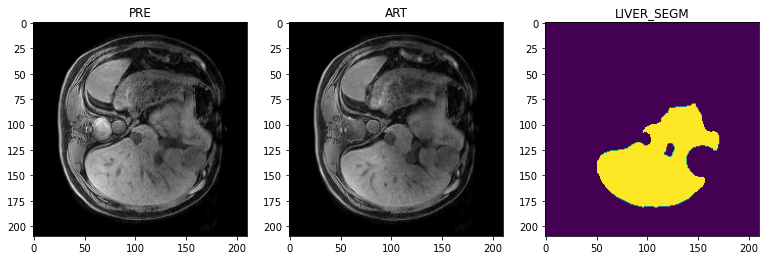

In [64]:
check_ds = monai.data.Dataset(data=external_test_data_dict[:1], transform=test_transforms)


check_loader = DataLoader(check_ds, batch_size=10, num_workers=0, collate_fn=pad_list_data_collate) #collate_fn=list_data_collate)
check_data = monai.utils.misc.first(check_loader)
print(check_data['PRE'].shape)
print(check_data['ART'].shape)


num_display = 10
if check_data['PRE'].shape[0] < num_display:
    num_display = check_data['PRE'].shape[0]

for i in range(num_display):
    acc_id, ART, PV , liver_label = (check_data['ACCESSION_ID'][i],check_data['PRE'][i][0],check_data['ART'][i][0], check_data['SEGM'][i][0])
    print(acc_id)
    
    print('PRE shape: {}, label shape: {}'.format(PRE.shape, liver_label.shape))
    print('PRE mean: {}'.format(np.mean(PRE.numpy())))
    
    
    print('ART shape: {}, label shape: {}'.format(ART.shape, liver_label.shape))
    print('ART mean: {}'.format(np.mean(ART.numpy())))
    


    slice_num = PRE.shape[2]//2
    
    plt.figure('check', (13, 15))

   
    plt.subplot(1, 3, 1)
    plt.title('PRE')
    plt.imshow(PRE[:,:,slice_num], cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title('ART')
    plt.imshow(ART[:,:,slice_num], cmap='gray')
    

    plt.subplot(1, 3, 3)
    plt.title('LIVER_SEGM')
    plt.imshow(liver_label[:,:,slice_num])
    plt.show()


    


torch.Size([1, 1, 210, 210, 100])
torch.Size([1, 1, 210, 210, 100])
tensor(1)
PRE shape: torch.Size([210, 210, 100]), label shape: torch.Size([210, 210, 100])
PRE mean: 0.06837198138237
ART shape: torch.Size([210, 210, 100]), label shape: torch.Size([210, 210, 100])
ART mean: 0.1549057960510254


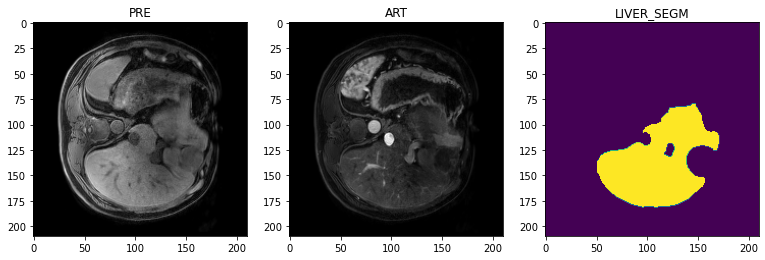

In [65]:
check_ds = monai.data.Dataset(data=external_test_data_dict[:1], transform=test_transforms)


check_loader = DataLoader(check_ds, batch_size=10, num_workers=0, collate_fn=list_data_collate) #pad_list_data_collate, collate_fn=list_data_collate)
check_data = monai.utils.misc.first(check_loader)
print(check_data['PRE'].shape)
print(check_data['ART'].shape)


num_display = 10
if check_data['ART'].shape[0] < num_display:
    num_display = check_data['ART'].shape[0]

for i in range(num_display):
    acc_id, PRE, ART , liver_label = (check_data['ACCESSION_ID'][i],check_data['PRE'][i][0],check_data['ART'][i][0], check_data['SEGM'][i][0])
    print(acc_id)
    
    print('PRE shape: {}, label shape: {}'.format(PRE.shape, liver_label.shape))
    print('PRE mean: {}'.format(np.mean(PRE.numpy())))
    
    
    print('ART shape: {}, label shape: {}'.format(ART.shape, liver_label.shape))
    print('ART mean: {}'.format(np.mean(ART.numpy())))
    


    slice_num = PRE.shape[2]//2
    
    plt.figure('check', (13, 15))

   
    plt.subplot(1, 3, 1)
    plt.title('PRE')
    plt.imshow(PRE[:,:,slice_num], cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title('ART')
    plt.imshow(ART[:,:,slice_num], cmap='gray')
    

    plt.subplot(1, 3, 3)
    plt.title('LIVER_SEGM')
    plt.imshow(liver_label[:,:,slice_num])
    plt.show()


    


0it [00:00, ?it/s]

torch.Size([2, 210, 210, 100])
torch.Size([1, 210, 210, 100])
torch.Size([1, 2, 210, 210, 100])
0.8387545347213745
108.81865646442228
43.959901721942785
torch.Size([2, 210, 210, 100])
torch.Size([1, 210, 210, 100])
torch.Size([1, 2, 210, 210, 100])
0.947256326675415
3.605551275463989
0.8755346890247949
torch.Size([1, 2, 210, 210, 100])
torch.Size([1, 210, 210, 100])


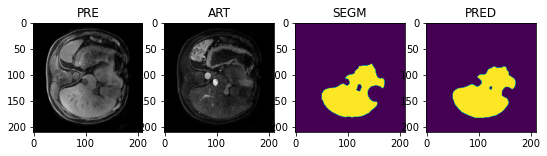

torch.Size([2, 230, 230, 125])
torch.Size([1, 230, 230, 125])
torch.Size([1, 2, 230, 230, 125])
0.9198014736175537
110.80162453682708
17.466827510416945
torch.Size([2, 230, 230, 125])
torch.Size([1, 230, 230, 125])
torch.Size([1, 2, 230, 230, 125])
0.950257420539856
7.0
1.3725696093084894
torch.Size([1, 2, 230, 230, 125])
torch.Size([1, 230, 230, 125])


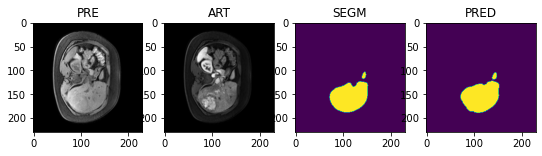

torch.Size([2, 228, 228, 105])
torch.Size([1, 228, 228, 105])
torch.Size([1, 2, 228, 228, 105])
0.8202285170555115
74.27987606796611
22.43440731236927
torch.Size([2, 228, 228, 105])
torch.Size([1, 228, 228, 105])
torch.Size([1, 2, 228, 228, 105])
0.933899462223053
3.0
1.2433076533537155
torch.Size([1, 2, 228, 228, 105])
torch.Size([1, 228, 228, 105])


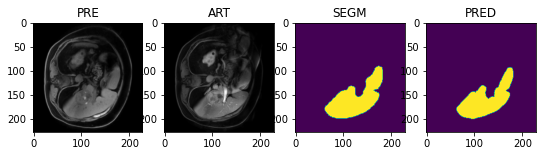

torch.Size([2, 211, 211, 104])
torch.Size([1, 211, 211, 104])
torch.Size([1, 2, 211, 211, 104])
0.5257752537727356
129.34450123604017
63.91105447436591
torch.Size([2, 211, 211, 104])
torch.Size([1, 211, 211, 104])
torch.Size([1, 2, 211, 211, 104])
0.0
134.77759457714032
79.04076207415362
torch.Size([1, 2, 211, 211, 104])
torch.Size([1, 211, 211, 104])


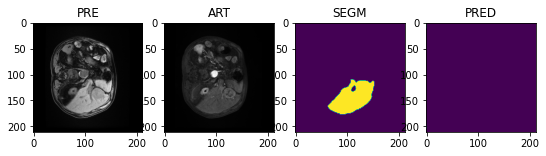

torch.Size([2, 191, 167, 118])
torch.Size([1, 191, 167, 118])
torch.Size([1, 2, 191, 167, 118])
0.7236391305923462
105.76388797694608
41.83313411477273
torch.Size([2, 191, 167, 118])
torch.Size([1, 191, 167, 118])
torch.Size([1, 2, 191, 167, 118])
0.7795398831367493
46.54030511288038
10.561620508987357
torch.Size([1, 2, 191, 167, 118])
torch.Size([1, 191, 167, 118])


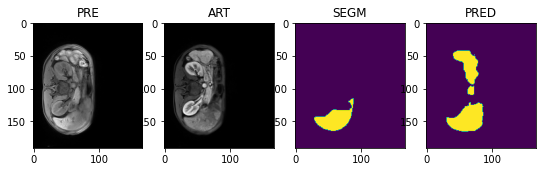

torch.Size([2, 211, 211, 109])
torch.Size([1, 211, 211, 109])
torch.Size([1, 2, 211, 211, 109])
0.7096734642982483
122.51020323603018
53.422221036377266
torch.Size([2, 211, 211, 109])
torch.Size([1, 211, 211, 109])
torch.Size([1, 2, 211, 211, 109])
0.9483680129051208
6.708203932499369
1.2099104578849942
torch.Size([1, 2, 211, 211, 109])
torch.Size([1, 211, 211, 109])


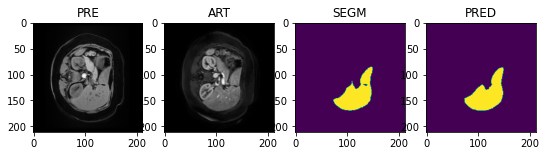

torch.Size([2, 201, 178, 108])
torch.Size([1, 201, 178, 108])
torch.Size([1, 2, 201, 178, 108])
0.9476144909858704
73.71838297846354
11.806370273343369
torch.Size([2, 201, 178, 108])
torch.Size([1, 201, 178, 108])
torch.Size([1, 2, 201, 178, 108])
0.9648875594139099
2.23606797749979
0.5373157554956589
torch.Size([1, 2, 201, 178, 108])
torch.Size([1, 201, 178, 108])


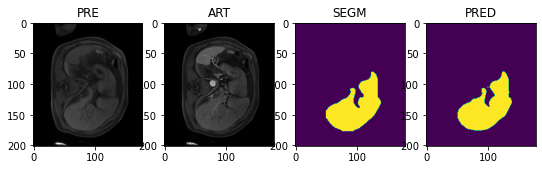

torch.Size([2, 204, 204, 100])
torch.Size([1, 204, 204, 100])
torch.Size([1, 2, 204, 204, 100])
0.8316083550453186
127.61347890228456
60.91265569906274
torch.Size([2, 204, 204, 100])
torch.Size([1, 204, 204, 100])
torch.Size([1, 2, 204, 204, 100])
0.9512306451797485
2.8284271247461903
0.8627096221484984
torch.Size([1, 2, 204, 204, 100])
torch.Size([1, 204, 204, 100])


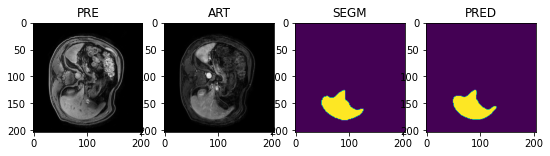

torch.Size([2, 189, 189, 105])
torch.Size([1, 189, 189, 105])
torch.Size([1, 2, 189, 189, 105])
0.8465262055397034
87.68124086713189
26.648481934060978
torch.Size([2, 189, 189, 105])
torch.Size([1, 189, 189, 105])
torch.Size([1, 2, 189, 189, 105])
0.9411359429359436
2.8284271247461903
0.9686609391165686
torch.Size([1, 2, 189, 189, 105])
torch.Size([1, 189, 189, 105])


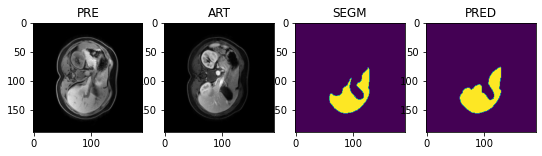

torch.Size([2, 201, 201, 96])
torch.Size([1, 201, 201, 96])
torch.Size([1, 2, 201, 201, 96])
0.7265499234199524
110.16351483136329
50.034406518469424
torch.Size([2, 201, 201, 96])
torch.Size([1, 201, 201, 96])
torch.Size([1, 2, 201, 201, 96])
0.9608673453330994
2.0
0.6942477097755845
torch.Size([1, 2, 201, 201, 96])
torch.Size([1, 201, 201, 96])


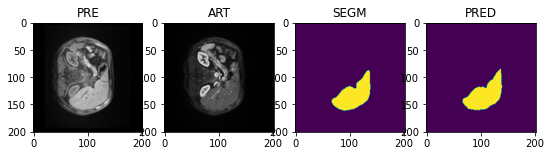

torch.Size([2, 210, 210, 100])
torch.Size([1, 210, 210, 100])
torch.Size([1, 2, 210, 210, 100])
0.7749069333076477
125.9666622037983
60.63901827212565
torch.Size([2, 210, 210, 100])
torch.Size([1, 210, 210, 100])
torch.Size([1, 2, 210, 210, 100])
0.9162604808807373
25.332783639565974
4.158747922810869
torch.Size([1, 2, 210, 210, 100])
torch.Size([1, 210, 210, 100])


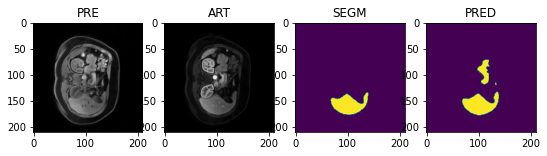

torch.Size([2, 210, 210, 110])
torch.Size([1, 210, 210, 110])
torch.Size([1, 2, 210, 210, 110])
0.8658704161643982
129.2253844823484
53.99275796846287
torch.Size([2, 210, 210, 110])
torch.Size([1, 210, 210, 110])
torch.Size([1, 2, 210, 210, 110])
0.9668436050415039
2.0
0.6699052078177972
torch.Size([1, 2, 210, 210, 110])
torch.Size([1, 210, 210, 110])


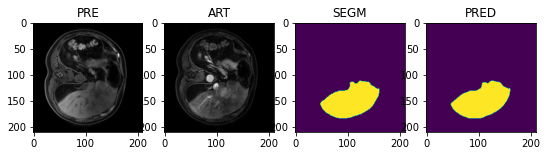

torch.Size([2, 210, 210, 125])
torch.Size([1, 210, 210, 125])
torch.Size([1, 2, 210, 210, 125])
0.9739997386932373
2.0
1.5859355490478426
torch.Size([2, 210, 210, 125])
torch.Size([1, 210, 210, 125])
torch.Size([1, 2, 210, 210, 125])
0.9742133617401123
2.0
0.6440549542317588
torch.Size([1, 2, 210, 210, 125])
torch.Size([1, 210, 210, 125])


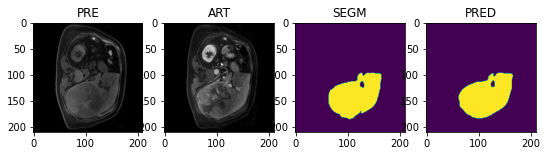

torch.Size([2, 172, 172, 100])
torch.Size([1, 172, 172, 100])
torch.Size([1, 2, 172, 172, 100])
0.8035767078399658
88.33459118601274
35.402595340989556
torch.Size([2, 172, 172, 100])
torch.Size([1, 172, 172, 100])
torch.Size([1, 2, 172, 172, 100])
0.8830008506774902
24.919871588754223
4.318960833640445
torch.Size([1, 2, 172, 172, 100])
torch.Size([1, 172, 172, 100])


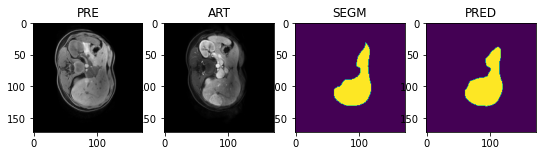

torch.Size([2, 221, 221, 114])
torch.Size([1, 221, 221, 114])
torch.Size([1, 2, 221, 221, 114])
0.9004043340682983
68.54195795277518
16.885530477753008
torch.Size([2, 221, 221, 114])
torch.Size([1, 221, 221, 114])
torch.Size([1, 2, 221, 221, 114])
0.967679500579834
2.23606797749979
0.6719624945770646
torch.Size([1, 2, 221, 221, 114])
torch.Size([1, 221, 221, 114])


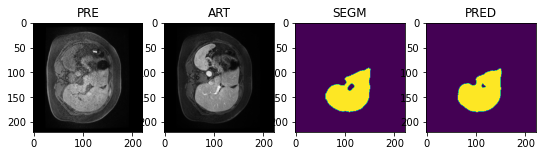

torch.Size([2, 207, 207, 105])
torch.Size([1, 207, 207, 105])
torch.Size([1, 2, 207, 207, 105])
0.8772106170654297
112.48288751362061
27.069410895128634
torch.Size([2, 207, 207, 105])
torch.Size([1, 207, 207, 105])
torch.Size([1, 2, 207, 207, 105])
0.9470486044883728
7.0710678118654755
1.386374048935795
torch.Size([1, 2, 207, 207, 105])
torch.Size([1, 207, 207, 105])


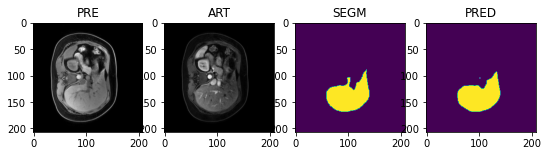

[0.8387545347213745, 0.9198014736175537, 0.8202285170555115, 0.5257752537727356, 0.7236391305923462, 0.7096734642982483, 0.9476144909858704, 0.8316083550453186, 0.8465262055397034, 0.7265499234199524, 0.7749069333076477, 0.8658704161643982, 0.9739997386932373, 0.8035767078399658, 0.9004043340682983, 0.8772106170654297]


DICE  POST_DICE        HD95   POST_HD95  InferenceTime
count  16.000000  16.000000   16.000000   16.000000      16.000000
mean    0.817884   0.877031   98.577928   17.192773       0.005361
std     0.110147   0.238589   33.011940   33.732563       0.002104
min     0.525775   0.000000    2.000000    2.000000       0.003376
25%     0.762818   0.929490   84.330900    2.236068       0.003639
50%     0.835181   0.947812  109.491086    3.302776       0.004879
75%     0.883009   0.961872  123.374318   11.533269       0.006325
max     0.974000   0.974213  129.344501  134.777595       0.010966

In [66]:
roi_size = (224, 224, 128)

df_external_test_results = run_inference_and_evaluate(
        model=model, 
        data_loader= external_test_loader, 
        roi_size=roi_size, 
        plot_images=True, 
        save_output=False) #, max_eval = 2

torch.cuda.empty_cache()
df_external_test_results['EXPERIMENT_ID'] = 'PARIS-PRE-ART'
df_external_test_results.describe()

In [67]:
df_external_test_results.to_csv('../ExternalTestingResults/Paris-PRE-ART.csv')